# Decision program using machine learning methods

In [1]:
!pip install scikit-learn
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install tqdm
#!pip install dhg

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
#import dhg
import torch.nn as nn
from copy import deepcopy

#### Distribution of the runtimes in orders of magnitude

For the original queries:

In [3]:
df = pd.read_csv('results/POS_Scala_comparison_TO_augment_server.csv')

df.loc[df['orig mean'] == 'TO', 'orig mean'] = 101
column = df['orig mean'].astype("float64")

count_0_01_orig = 0
count_0_1_orig = 0
count_1_orig = 0
count_10_orig = 0
count_100_orig = 0
count_TO_orig = 0

for value in column:
    if value <= 0.01:
        count_0_01_orig += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_orig += 1
    elif value > 0.1 and value <= 1:
        count_1_orig += 1
    elif value > 1 and value <= 10:
        count_10_orig += 1
    elif value > 10 and value <= 100:
        count_100_orig += 1
    else:
        count_TO_orig += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_orig)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_orig)
print("Number of instances with original runtime (0.1, 1]:", count_1_orig)
print("Number of instances with original runtime (1,10]:", count_10_orig)
print("Number of instances with original runtime (10,100]:", count_100_orig)
print("Number of instances with original runtime TO:", count_TO_orig)

Number of instances with original runtime <= 0.01: 115
Number of instances with original runtime (0.01, 0.1]: 797
Number of instances with original runtime (0.1, 1]: 1053
Number of instances with original runtime (1,10]: 434
Number of instances with original runtime (10,100]: 244
Number of instances with original runtime TO: 293


for the rewritten queries:

In [4]:
df.loc[df['rewr mean'] == 'TO', 'rewr mean'] = 101
column = df['rewr mean'].astype("float64")

count_0_01_rewr = 0
count_0_1_rewr = 0
count_1_rewr = 0
count_10_rewr = 0
count_100_rewr = 0
count_TO_rewr = 0

for value in column:
    if value <= 0.01:
        count_0_01_rewr += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_rewr += 1
    elif value > 0.1 and value <= 1:
        count_1_rewr += 1
    elif value > 1 and value <= 10:
        count_10_rewr += 1
    elif value > 10 and value <= 100:
        count_100_rewr += 1
    else:
        count_TO_rewr += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_rewr)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_rewr)
print("Number of instances with original runtime (0.1, 1]:", count_1_rewr)
print("Number of instances with original runtime (1,10]:", count_10_rewr)
print("Number of instances with original runtime (10,100]:", count_100_rewr)
print("Number of instances with original runtime TO:", count_TO_rewr)

Number of instances with original runtime <= 0.01: 1
Number of instances with original runtime (0.01, 0.1]: 522
Number of instances with original runtime (0.1, 1]: 1937
Number of instances with original runtime (1,10]: 227
Number of instances with original runtime (10,100]: 208
Number of instances with original runtime TO: 41


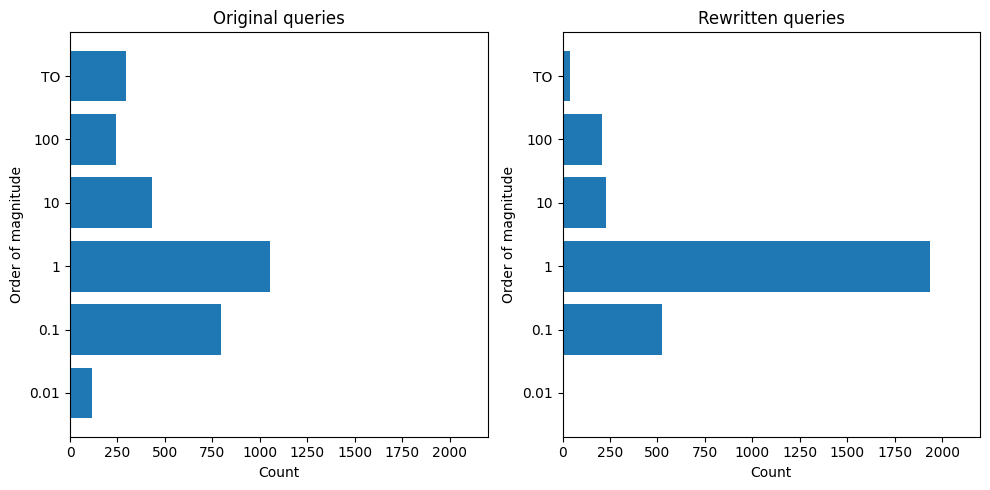

In [5]:
numbers_orig = [count_0_01_orig, count_0_1_orig, count_1_orig, count_10_orig, count_100_orig, count_TO_orig]
numbers_rewr = [count_0_01_rewr, count_0_1_rewr, count_1_rewr, count_10_rewr, count_100_rewr, count_TO_rewr]

# Indices for each number
indices = ["0.01", "0.1", "1", "10", "100", "TO"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot original numbers
axs[0].barh(indices, numbers_orig)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Order of magnitude')
axs[0].set_title('Original queries')
axs[0].set_xlim(0, 2200)

# Plot rewritten numbers
axs[1].barh(indices, numbers_rewr)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Order of magnitude')
axs[1].set_title('Rewritten queries')
axs[1].set_xlim(0, 2200)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Import the data

In [6]:
file_path = 'results/features_times_POS.csv'
df = pd.read_csv(file_path)
df.head()

,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,diff rewr+rewr-orig,#relations,...,min(branching factors),max(branching factors),mean(branching factors),median(branching factors),q25(branching factors),q75(branching factors),balancedness factor,container counts list,branching factors list,text
0,STATS,001-014,orig,orig,0.030513,0.063829,1.989236,0.033316,1.958724,3,...,2,2,2.0,2.0,2.0,2.0,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],"SELECT MIN(u.Id) FROM comments as c, votes as ..."
1,STATS,001-014-augA1,orig,orig,0.030952,0.043271,1.840104,0.012320,1.809152,3,...,1,1,1.0,1.0,1.0,1.0,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]","SELECT MIN(c.id) FROM comments as c, votes as ..."
2,STATS,001-014-augA2,orig,orig,0.030812,0.168679,1.987010,0.137867,1.956198,3,...,1,1,1.0,1.0,1.0,1.0,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]","SELECT MIN(v.id) FROM comments as c, votes as ..."
3,STATS,001-014-augF1,orig,orig,0.029663,0.156431,1.988726,0.126768,1.959062,3,...,2,2,2.0,2.0,2.0,2.0,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],"SELECT MIN(u.Id) FROM comments as c, votes as ..."
4,STATS,001-014-augF1-augA1,orig,orig,0.030595,0.043383,1.898386,0.012788,1.867790,3,...,1,1,1.0,1.0,1.0,1.0,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]","SELECT MIN(c.id) FROM comments as c, votes as ..."


In [7]:
df.dtypes

bench                         object
query                         object
orig/rewr(mean)               object
orig/rewr+rewr(mean)          object
orig mean                    float64
rewr mean                    float64
rewr mean+rewr               float64
diff rewr-orig               float64
diff rewr+rewr-orig          float64
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
median(container counts)     float64
q75(container counts)        float64
min(branching factors)         int64
max(branching factors)         int64
mean(branching factors)      float64
median(branching factors)    float64
q25(branching factors)       float64
q75(branching factors)       float64
balancedness factor          float64
c

#### Delete those examples, where both methods gave a timeout

In [8]:
df[df["orig/rewr(mean)"] == "-"]

,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,diff rewr+rewr-orig,#relations,...,min(branching factors),max(branching factors),mean(branching factors),median(branching factors),q25(branching factors),q75(branching factors),balancedness factor,container counts list,branching factors list,text
2071,SNAP,wiki-path05,-,-,100.0,100.0,100.0,0.0,0.0,6,...,1,2,1.250000,1.0,1.00,1.25,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 2]","select MIN(p1.toNode) from wiki p1, wiki p2, w..."
2072,SNAP,wiki-path05-augA1,-,-,100.0,100.0,100.0,0.0,0.0,6,...,1,2,1.250000,1.0,1.00,1.25,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 2]","select MIN(p2.fromnode) from wiki p1, wiki p2,..."
2073,SNAP,wiki-path05-augA2,-,-,100.0,100.0,100.0,0.0,0.0,6,...,1,2,1.250000,1.0,1.00,1.25,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 2]","select MIN(p3.fromnode) from wiki p1, wiki p2,..."
2074,SNAP,wiki-path05-augA3,-,-,100.0,100.0,100.0,0.0,0.0,6,...,1,2,1.250000,1.0,1.00,1.25,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 2]","select MIN(p4.fromnode) from wiki p1, wiki p2,..."
2075,SNAP,wiki-path05-augA4,-,-,100.0,100.0,100.0,0.0,0.0,6,...,1,2,1.250000,1.0,1.00,1.25,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 2]","select MIN(p5.fromnode) from wiki p1, wiki p2,..."
2076,SNAP,wiki-path05-augA5,-,-,100.0,100.0,100.0,0.0,0.0,6,...,1,2,1.250000,1.0,1.00,1.25,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 2]","select MIN(p6.fromnode) from wiki p1, wiki p2,..."
2077,SNAP,wiki-path06,-,-,100.0,100.0,100.0,0.0,0.0,7,...,1,2,1.200000,1.0,1.00,1.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 1, 2]","select MIN(p1.toNode) from wiki p1, wiki p2, w..."
2078,SNAP,wiki-path06-augA1,-,-,100.0,100.0,100.0,0.0,0.0,7,...,1,2,1.200000,1.0,1.00,1.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 1, 2]","select MIN(p2.fromnode) from wiki p1, wiki p2,..."
2079,SNAP,wiki-path06-augA2,-,-,100.0,100.0,100.0,0.0,0.0,7,...,1,2,1.200000,1.0,1.00,1.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 1, 2]","select MIN(p3.fromnode) from wiki p1, wiki p2,..."
2080,SNAP,wiki-path06-augA3,-,-,100.0,100.0,100.0,0.0,0.0,7,...,1,2,1.200000,1.0,1.00,1.00,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 1, 2]","select MIN(p4.fromnode) from wiki p1, wiki p2,..."


For the SNAP dataset the wiki-path06, wiki-path07, wiki-path08 and wiki-tree03 (for all augmentation cases) did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those 32 samples.

In [9]:
df = df[df["orig/rewr(mean)"] != "-"]
df.shape

(2898, 30)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [10]:
X = df.iloc[:, 9:26]
X.head()

,#relations,#conditions,#filters,#joins,depth,min(container counts),max(container counts),mean(container counts),q25(container counts),median(container counts),q75(container counts),min(branching factors),max(branching factors),mean(branching factors),median(branching factors),q25(branching factors),q75(branching factors)
0,3,7,5,2,1,1,3,1.133333,1.0,1.0,1.0,2,2,2.0,2.0,2.0,2.0
1,3,7,5,2,2,1,3,1.133333,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0
2,3,7,5,2,2,1,3,1.133333,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0
3,3,7,5,2,1,1,3,1.133333,1.0,1.0,1.0,2,2,2.0,2.0,2.0,2.0
4,3,7,5,2,2,1,3,1.133333,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0


#### Log-transformations

This basic features do not need log transformations.

In [11]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

,Min,Max,Diff
#relations,2.000000,11.0,9.000000
#conditions,2.000000,20.0,18.000000
#filters,0.000000,16.0,16.000000
#joins,1.000000,12.0,11.000000
depth,1.000000,7.0,6.000000
min(container counts),1.000000,1.0,0.000000
max(container counts),2.000000,5.0,3.000000
mean(container counts),1.047619,1.6,0.552381
q25(container counts),1.000000,1.0,0.000000
median(container counts),1.000000,1.0,0.000000


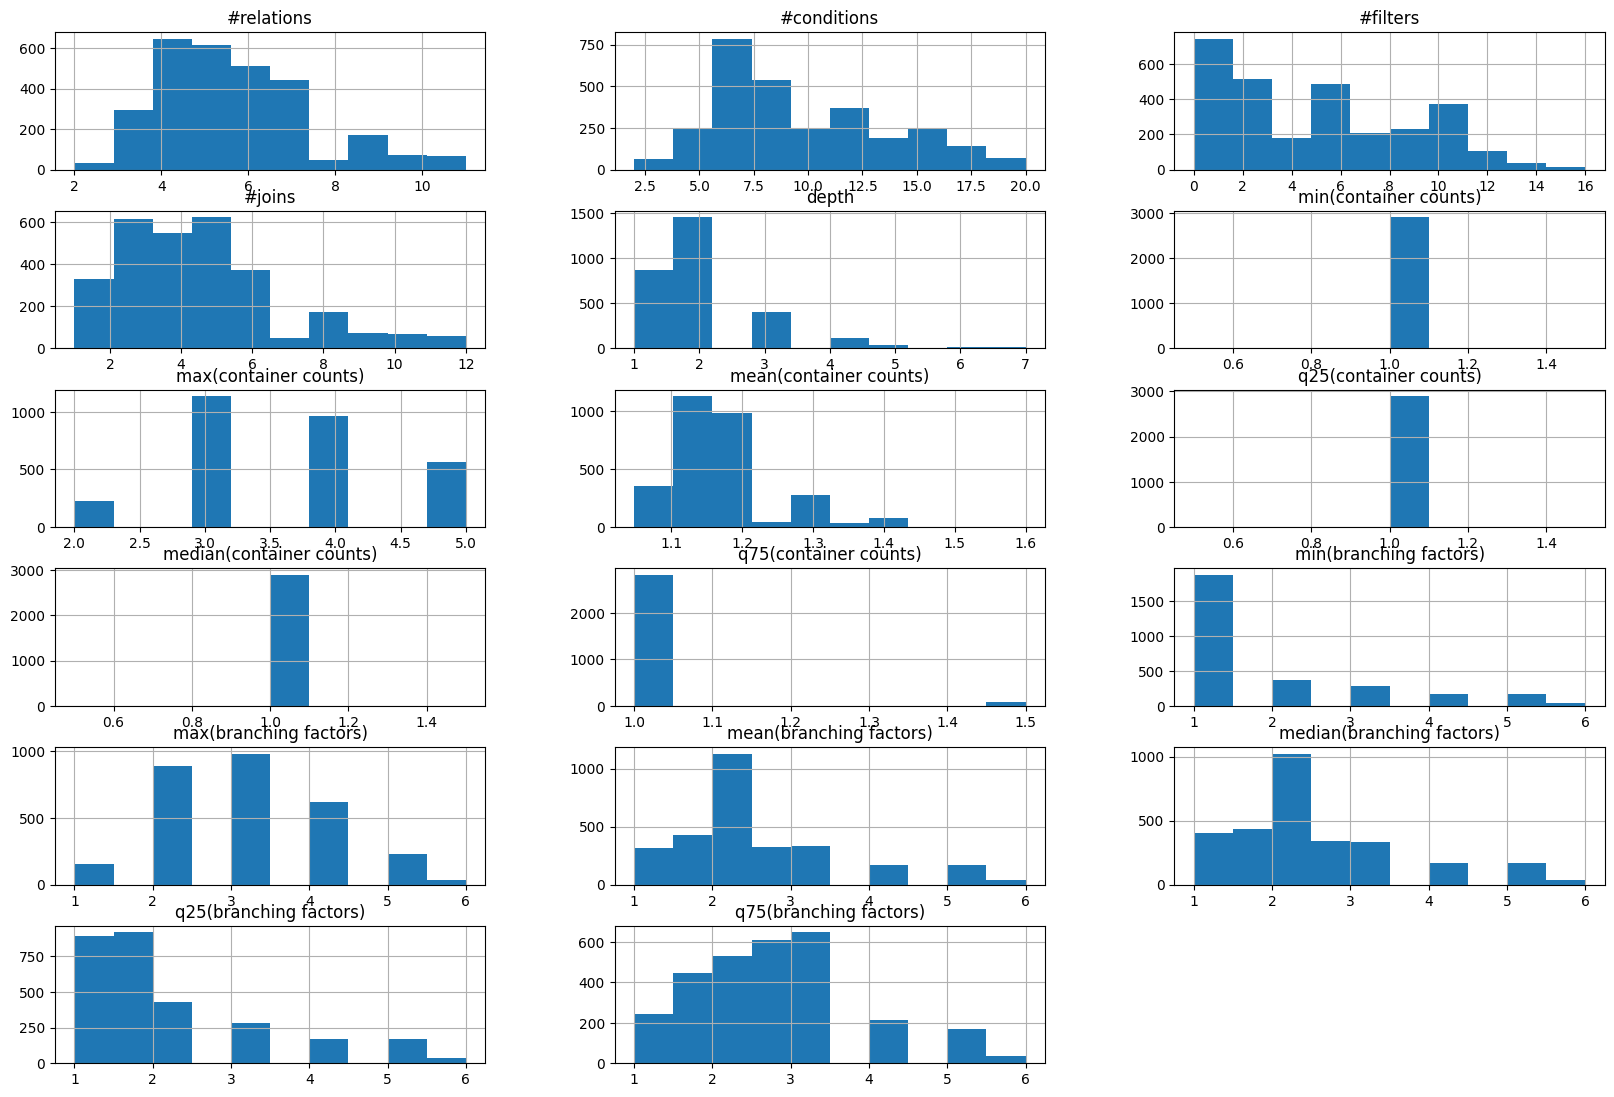

In [12]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Boxplots of running times for both cases (either original or rewritten)

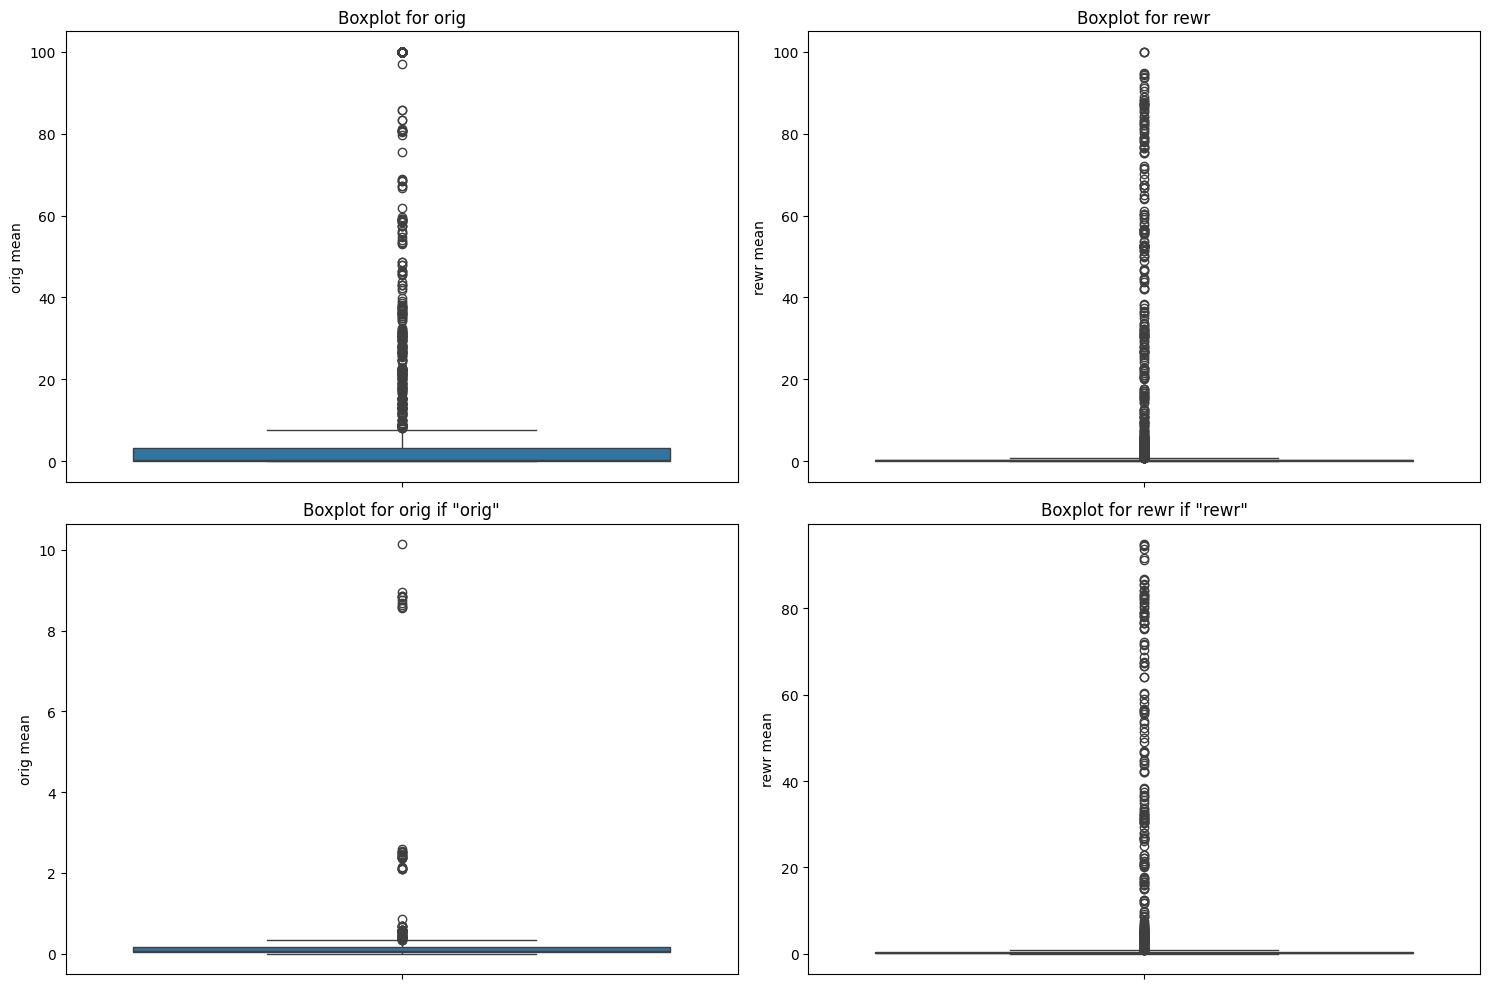

In [13]:
df_orig = df[df['orig/rewr(mean)'] == 'orig']
df_rewr = df[df['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(y='orig mean', data=df, ax=axes[0,0])
axes[0,0].set_title(f'Boxplot for orig')

sns.boxplot(y='rewr mean', data=df, ax=axes[0,1])
axes[0,1].set_title(f'Boxplot for rewr')

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'Boxplot for orig if "orig"')

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'Boxplot for rewr if "rewr"')

plt.tight_layout()
plt.show()

The runtimes are highly skewed. Therefore, we log transform them

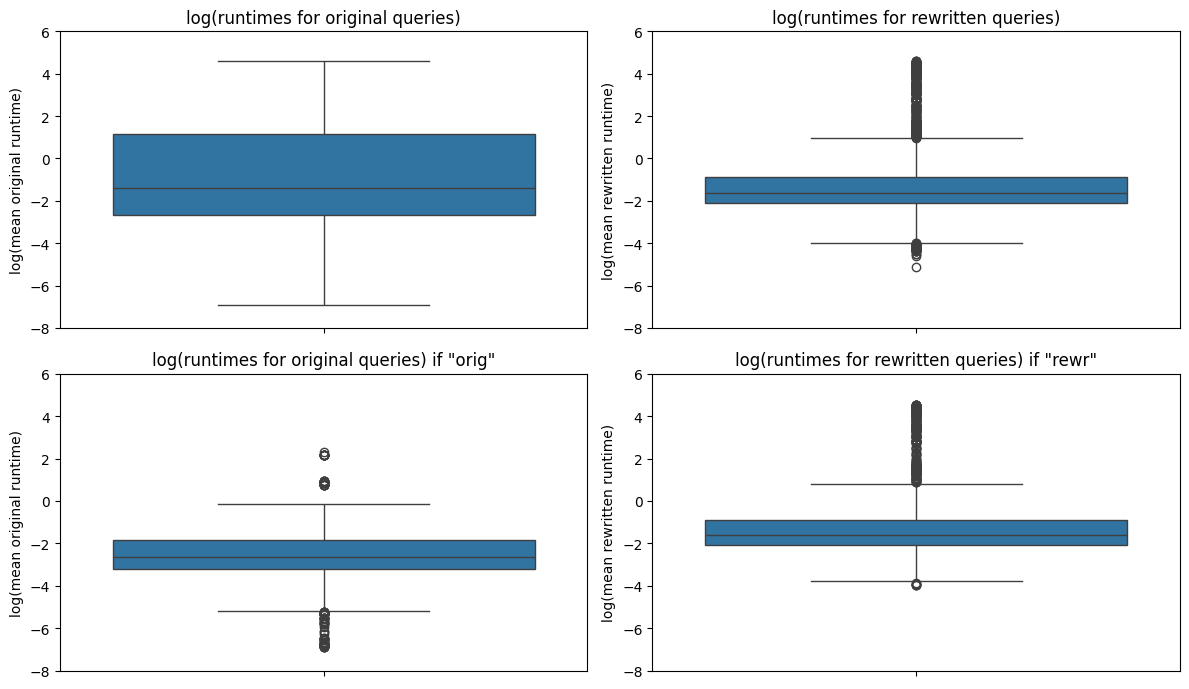

In [14]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(12,7))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0,0])
axes[0,0].set_title(f'log(runtimes for original queries)')
axes[0,0].set_ylabel("log(mean original runtime)")
axes[0,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[0,1])
axes[0,1].set_title(f'log(runtimes for rewritten queries)')
axes[0,1].set_ylabel("log(mean rewritten runtime)")
axes[0,1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'log(runtimes for original queries) if "orig"')
axes[1,0].set_ylabel("log(mean original runtime)")
axes[1,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[1,1].set_ylabel("log(mean rewritten runtime)")
axes[1,1].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

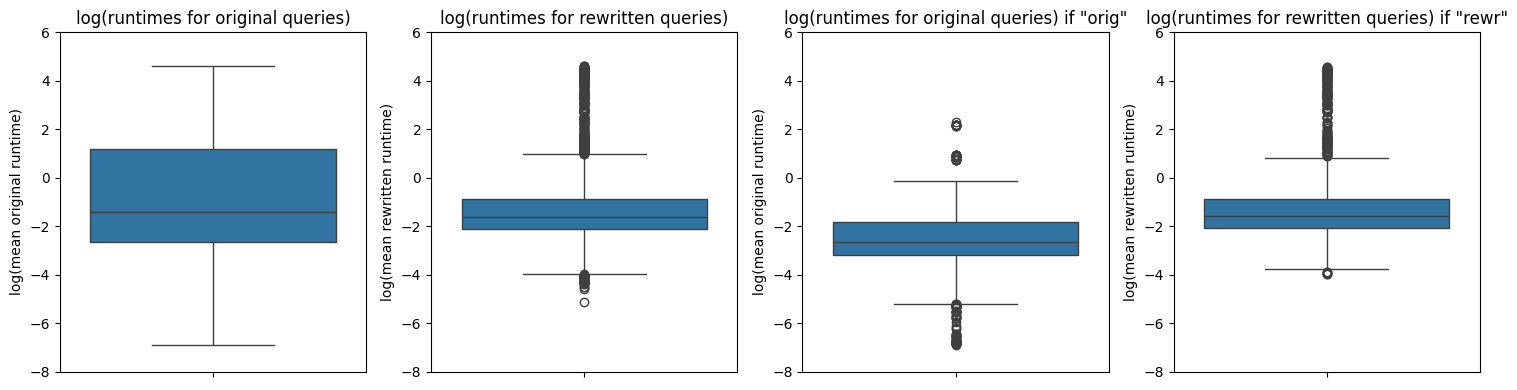

In [15]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(1,4, figsize=(15,4))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0])
axes[0].set_title(f'log(runtimes for original queries)')
axes[0].set_ylabel("log(mean original runtime)")
axes[0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[1])
axes[1].set_title(f'log(runtimes for rewritten queries)')
axes[1].set_ylabel("log(mean rewritten runtime)")
axes[1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[2])
axes[2].set_title(f'log(runtimes for original queries) if "orig"')
axes[2].set_ylabel("log(mean original runtime)")
axes[2].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[3])
axes[3].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[3].set_ylabel("log(mean rewritten runtime)")
axes[3].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

#### Scatterplot of running times

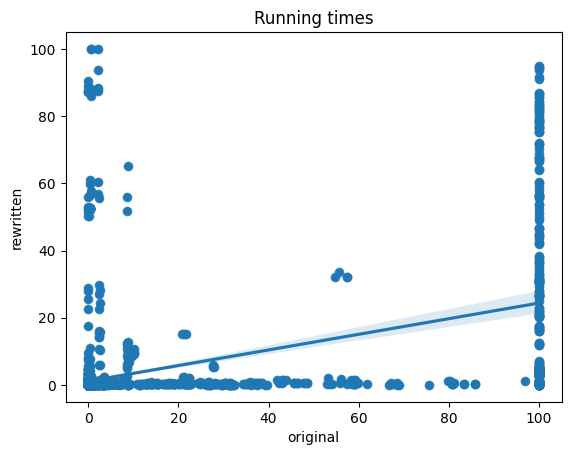

In [16]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df)
sns.regplot(x="orig mean", y="rewr mean", data=df) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

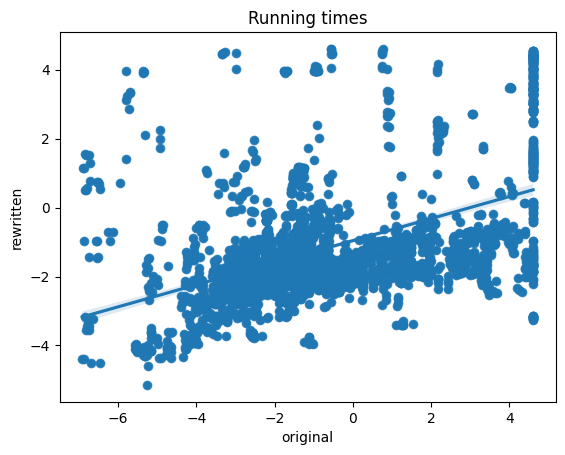

In [17]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df_log)
sns.regplot(x="orig mean", y="rewr mean", data=df_log) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [18]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(mean)'].map(mapping)
y1.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr(mean), dtype: int64

The number of appearances of original and rewritten is very balanced.

In [19]:
y1.value_counts()

orig/rewr(mean)
1    1480
0    1418
Name: count, dtype: int64

In [20]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["orig", "rewr", "equal"]
count

orig     1418
rewr     1480
equal       -
dtype: object

In [21]:
df["orig/rewr(mean)"].value_counts()

orig/rewr(mean)
rewr    1480
orig    1418
Name: count, dtype: int64

#### Classification response with three cases

In [22]:
condition = abs(df["diff rewr-orig"]) < 0.5
df["orig/rewr/equal 0.5"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.5'] = 'equal'

In [23]:
condition = abs(df["diff rewr-orig"]) < 0.1
df["orig/rewr/equal 0.1"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.1'] = 'equal'

In [24]:
condition = abs(df["diff rewr-orig"]) < 0.05
df["orig/rewr/equal 0.05"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.05'] = 'equal'

In [25]:
condition = abs(df["diff rewr-orig"]) < 0.01
df["orig/rewr/equal 0.01"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.01'] = 'equal'

In [26]:
count_05 = df["orig/rewr/equal 0.5"].value_counts()
count_01 = df["orig/rewr/equal 0.1"].value_counts()
count_005 = df["orig/rewr/equal 0.05"].value_counts()
count_001 = df["orig/rewr/equal 0.01"].value_counts()

In [27]:
count_001

orig/rewr/equal 0.01
rewr     1435
orig     1322
equal     141
Name: count, dtype: int64

In [28]:
counts = pd.concat([count_001, count_005, count_01, count_05], axis = 1)
counts.iloc[[0, 1]] = counts.iloc[[1, 0]].values
counts.index = ["orig", "rewr", "equal"]
counts = pd.concat([count, counts], axis = 1)
counts.columns = ["2 classes", "3 classes (0.01)", "3 classes (0.05)", "3 classes (0.1)", "3 classes (0.5)"]
counts

,2 classes,3 classes (0.01),3 classes (0.05),3 classes (0.1),3 classes (0.5)
orig,1418,1322,1007,706,240
rewr,1480,1435,1336,1243,989
equal,-,141,555,949,1669


In [29]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_05 = df['orig/rewr/equal 0.5'].map(mapping1)
y1_equal_05.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr/equal 0.5, dtype: int64

In [30]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_01 = df['orig/rewr/equal 0.1'].map(mapping1)
y1_equal_01.head()

0    0
1    0
2   -1
3   -1
4    0
Name: orig/rewr/equal 0.1, dtype: int64

In [31]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_005 = df['orig/rewr/equal 0.05'].map(mapping1)
y1_equal_005.head()

0    0
1    0
2   -1
3   -1
4    0
Name: orig/rewr/equal 0.05, dtype: int64

In [32]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_001 = df['orig/rewr/equal 0.01'].map(mapping1)
y1_equal_001.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: orig/rewr/equal 0.01, dtype: int64

#### Regression response

We also have the time differences between the original and rewritten method and we want to use that as numerical response.

In [33]:
y1_diff = df["diff rewr-orig"]
#y1_diff = df["diff rewr+rewr-orig"]

We can see that the time difference has a wide range of values (or is skewed).

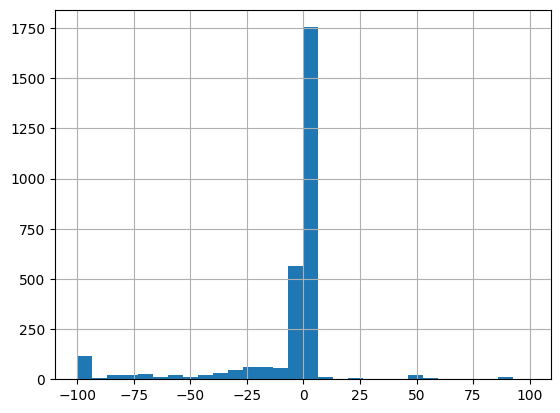

In [34]:
y1_diff.hist(bins = 30)
plt.show()

Therefore, we are going to transform it. As before with the features, we would like to apply a log transformation. Neverthless, since we have negative values this cannot be applied directly. We are going to multiple to log of the absolute values with the sign they had before. Additionally, since we have a lot of values close to zero, which leads to very low log values, we add 1 to the absolute values, which is a common method.   
$x = sgn(x) * log(|x| + 1)$

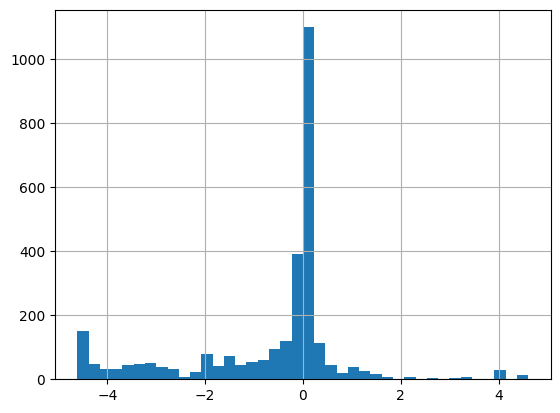

In [35]:
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) +1)
y1_diff_log.hist(bins = 40)
plt.show()

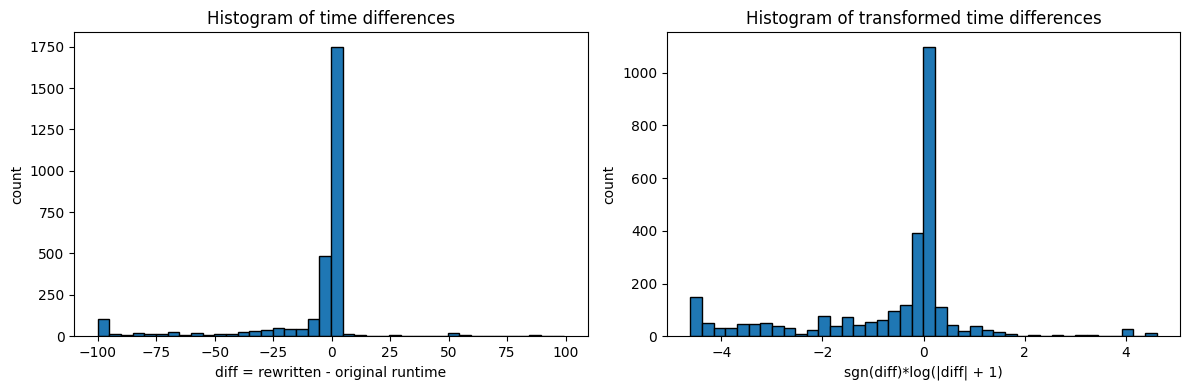

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(y1_diff, bins=40, edgecolor='black')
axs[0].set_title('Histogram of time differences')
axs[0].set_ylabel("count")
axs[0].set_xlabel("diff = rewritten - original runtime")

# Create the second histogram
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) + 1)
axs[1].hist(y1_diff_log, bins=40, edgecolor='black')
axs[1].set_title('Histogram of transformed time differences')
axs[1].set_ylabel("count")
axs[1].set_xlabel("sgn(diff)*log(|diff| + 1)")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [37]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)
y1_diff_log_train = y1_diff_log.loc[y1_train.index]
y1_diff_log_val = y1_diff_log.loc[y1_val.index]
y1_diff_log_test = y1_diff_log.loc[y1_test.index]
y1_equal_05_train = y1_equal_05.loc[y1_train.index]
y1_equal_05_val = y1_equal_05.loc[y1_val.index]
y1_equal_05_test = y1_equal_05.loc[y1_test.index]
y1_equal_01_train = y1_equal_01.loc[y1_train.index]
y1_equal_01_val = y1_equal_01.loc[y1_val.index]
y1_equal_01_test = y1_equal_01.loc[y1_test.index]
y1_equal_005_train = y1_equal_005.loc[y1_train.index]
y1_equal_005_val = y1_equal_005.loc[y1_val.index]
y1_equal_005_test = y1_equal_005.loc[y1_test.index]
y1_equal_001_train = y1_equal_001.loc[y1_train.index]
y1_equal_001_val = y1_equal_001.loc[y1_val.index]
y1_equal_001_test = y1_equal_001.loc[y1_test.index]

#### Cross-validation split

We take the same 10% as test set and use the rest for cross-validation.

In [38]:
X_train_cv = pd.concat([X_train, X_val], axis = 0)
y1_train_cv = pd.concat([y1_train, y1_val], axis = 0)
y1_diff_log_train_cv = pd.concat([y1_diff_log_train, y1_diff_log_val], axis = 0)
y1_equal_05_train_cv = pd.concat([y1_equal_05_train, y1_equal_05_val], axis = 0)
y1_equal_01_train_cv = pd.concat([y1_equal_01_train, y1_equal_01_val], axis = 0)
y1_equal_005_train_cv = pd.concat([y1_equal_005_train, y1_equal_005_val], axis = 0)
y1_equal_001_train_cv = pd.concat([y1_equal_001_train, y1_equal_001_val], axis = 0)

## ML models

In [39]:
table_2_classes = pd.DataFrame(columns=['acc', 'rec', 'acc', 'rec'])
table_3_classes = pd.DataFrame(columns=['acc', 'rec-mic', 'rec_mac', 'acc', 'rec-mic', 'rec-mac'])
table_time_diff = pd.DataFrame(columns=['MSE', 'MAE', 'R2', 'MSE', 'MAE', 'R2'])

### k-Nearest Neighbors with two classes

Train-test split:

In [40]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_train)
y1_pred_knn = clf.predict(X_val)

In [41]:
accuracy = accuracy_score(y1_val, y1_pred_knn)
recall = recall_score(y1_val, y1_pred_knn)
conf_matrix = confusion_matrix(y1_val, y1_pred_knn)
conf_matrix

array([[109,  18],
       [ 36, 127]])

CV:

In [42]:
y1_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [43]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_knn_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv

array([[1030,  244],
       [ 244, 1090]])

Adding the values to the result table:

In [44]:
table_2_classes.loc["5-NN"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.813793,0.779141,0.812883,0.817091


### k-Nearest Neighbors with three classes

##### equal cut off: 0.5

Train-test split:

In [45]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_knn = clf.predict(X_val)

In [46]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_knn)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_knn)
conf_matrix

array([[ 23,   2,   0],
       [  6, 142,  21],
       [  1,  17,  78]])

CV:

In [47]:
y1_equal_05_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [48]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
conf_matrix_cv

array([[ 174,   44,    1],
       [  52, 1251,  186],
       [  10,  165,  725]])

Adding the values to the result table:

In [49]:
table_3_classes.loc["5-NN 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412


##### equal cut off: 0.1

Train-test split:

In [50]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_knn = clf.predict(X_val)

In [51]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_knn)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_knn)
conf_matrix

array([[ 47,   7,   5],
       [ 18,  65,  14],
       [ 10,  15, 109]])

CV:

In [52]:
y1_equal_01_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [53]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
conf_matrix_cv

array([[429, 124,  69],
       [154, 548, 155],
       [ 80, 112, 937]])

Adding the values to the result table:

In [54]:
table_3_classes.loc["5-NN 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696


##### equal cut off: 0.05

Train-test split:

In [55]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_knn = clf.predict(X_val)

In [56]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_knn)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_knn)
conf_matrix

array([[ 78,   7,   8],
       [ 21,  20,  15],
       [ 20,  12, 109]])

CV:

In [57]:
y1_equal_005_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [58]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
conf_matrix_cv

array([[700,  80, 119],
       [183, 179, 138],
       [146,  90, 973]])

Adding the values to the result table:

In [59]:
table_3_classes.loc["5-NN 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147


##### equal cut off: 0.01

Train-test split:

In [60]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_knn = clf.predict(X_val)

In [61]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_knn)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_knn)
conf_matrix

array([[101,   1,  17],
       [ 12,   0,   7],
       [ 33,   1, 118]])

CV:

In [62]:
y1_equal_001_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [63]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
conf_matrix_cv

array([[ 961,   13,  212],
       [  69,    8,   52],
       [ 242,    8, 1043]])

Adding the values to the result table:

In [64]:
table_3_classes.loc["5-NN 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651


### k-Nearest Neighbors with time difference

Train-test split:

In [65]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y1_diff_log_train)
y1_pred_knn = model.predict(X_val)

In [66]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_knn)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_knn)
r2 = r2_score(y1_diff_log_val, y1_pred_knn)

CV:

In [67]:
y1_pred_knn_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [68]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_knn_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_knn_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_knn_cv)

Adding the values to the result table:

In [69]:
table_time_diff.loc["5-NN"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.649719,0.477766,0.763458,0.766804,0.51984,0.723023


### Decision tree with two classes

Train-test split:

In [70]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [71]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
recall = recall_score(y1_val, y1_pred_dec_tree)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

array([[118,   9],
       [ 43, 120]])

CV:

In [72]:
y1_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [73]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_dec_tree_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv

array([[1096,  178],
       [ 271, 1063]])

Adding the values to the result table:

In [74]:
table_2_classes.loc["Decision tree"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.813793,0.779141,0.812883,0.817091
Decision tree,0.820690,0.736196,0.827837,0.796852


### Decision tree with three classes

##### equal cut off: 0.5

Train-test split:

In [75]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_dec_tree = clf.predict(X_val)

In [76]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_dec_tree)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_dec_tree)
conf_matrix

array([[ 22,   3,   0],
       [  4, 152,  13],
       [  0,  17,  79]])

CV:

In [77]:
y1_equal_05_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [78]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
conf_matrix_cv

array([[ 165,   54,    0],
       [  31, 1324,  134],
       [   7,  177,  716]])

Adding the values to the result table:

In [79]:
table_3_classes.loc["Decision tree 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723


##### equal cut off: 0.1

Train-test split:

In [80]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_dec_tree = clf.predict(X_val)

In [81]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_dec_tree)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_dec_tree)
conf_matrix

array([[ 42,  12,   5],
       [ 13,  75,   9],
       [  3,  23, 108]])

CV:

In [82]:
y1_equal_01_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [83]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
conf_matrix_cv

array([[428, 141,  53],
       [151, 583, 123],
       [ 57, 137, 935]])

Adding the values to the result table:

In [84]:
table_3_classes.loc["Decision tree 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183


##### equal cut off: 0.05

Train-test split:

In [85]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [86]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

array([[ 82,   5,   6],
       [ 20,  22,  14],
       [ 18,  11, 112]])

CV:

In [87]:
y1_equal_005_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [88]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
conf_matrix_cv

array([[732,  70,  97],
       [189, 184, 127],
       [145,  85, 979]])

Adding the values to the result table:

In [89]:
table_3_classes.loc["Decision tree 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999


##### equal cut off: 0.01

Train-test split:

In [90]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [91]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

array([[108,   2,   9],
       [ 12,   0,   7],
       [ 36,   3, 113]])

CV:

In [92]:
y1_equal_001_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [93]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
conf_matrix_cv

array([[1014,   13,  159],
       [  64,   12,   53],
       [ 252,   22, 1019]])

Adding the values to the result table:

In [94]:
table_3_classes.loc["Decision tree 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696


### Decision tree with time difference

Train-test split:

In [95]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [96]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_dec_tree)
r2 = r2_score(y1_diff_log_val, y1_pred_dec_tree)

CV:

In [97]:
y1_pred_dec_tree_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [98]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_dec_tree_cv)

Adding the values to the result table:

In [99]:
table_time_diff.loc["Decision tree"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.649719,0.477766,0.763458,0.766804,0.519840,0.723023
Decision tree,0.569169,0.451612,0.792784,0.664213,0.481362,0.760080


### Random forest with two classes

Train-test split:

In [100]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_val)

In [101]:
accuracy = accuracy_score(y1_val, y1_pred_rand_forest)
recall = recall_score(y1_val, y1_pred_rand_forest)
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest)
conf_matrix

array([[118,   9],
       [ 41, 122]])

CV:

In [102]:
y1_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [103]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_rand_forest_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv

array([[1077,  197],
       [ 249, 1085]])

Adding the values to the result table:

In [104]:
table_2_classes.loc["Random forest"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.813793,0.779141,0.812883,0.817091
Decision tree,0.820690,0.736196,0.827837,0.796852
Random forest,0.827586,0.748466,0.828988,0.813343


### Random forest with three classes

##### equal cut off: 0.5

Train-test split:

In [105]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_rand_forest = clf.predict(X_val)

In [106]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_rand_forest)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_rand_forest)
conf_matrix

array([[ 22,   3,   0],
       [  4, 148,  17],
       [  0,  15,  81]])

CV:

In [107]:
y1_equal_05_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [108]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
conf_matrix_cv

array([[ 164,   54,    1],
       [  27, 1312,  150],
       [   5,  156,  739]])

Adding the values to the result table:

In [109]:
table_3_classes.loc["Random forest 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033


##### equal cut off: 0.1

Train-test split:

In [110]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_rand_forest = clf.predict(X_val)

In [111]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_rand_forest)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_rand_forest)
conf_matrix

array([[ 42,  12,   5],
       [ 12,  75,  10],
       [  2,  23, 109]])

CV:

In [112]:
y1_equal_01_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [113]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
conf_matrix_cv

array([[409, 155,  58],
       [123, 601, 133],
       [ 45, 131, 953]])

Adding the values to the result table:

In [114]:
table_3_classes.loc["Random forest 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.05

Train-test split:

In [115]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_rand_forest = clf.predict(X_val)

In [116]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_rand_forest)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_rand_forest)
conf_matrix

array([[ 79,   7,   7],
       [ 18,  24,  14],
       [ 15,  12, 114]])

CV:

In [117]:
y1_equal_005_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [118]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
conf_matrix_cv

array([[ 704,   84,  111],
       [ 172,  193,  135],
       [ 122,   81, 1006]])

Adding the values to the result table:

In [119]:
table_3_classes.loc["Random forest 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.01

Train-test split:

In [120]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_rand_forest = clf.predict(X_val)

In [121]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_rand_forest)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_rand_forest)
conf_matrix

array([[107,   2,  10],
       [ 10,   1,   8],
       [ 32,   3, 117]])

CV:

In [122]:
y1_equal_001_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [123]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
conf_matrix_cv

array([[ 994,   17,  175],
       [  58,   15,   56],
       [ 217,   18, 1058]])

Adding the values to the result table:

In [124]:
table_3_classes.loc["Random forest 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


### Random forest with time difference

Train-test split:

In [125]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_val)

In [126]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_rand_forest)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_rand_forest)
r2 = r2_score(y1_diff_log_val, y1_pred_rand_forest)

CV:

In [127]:
y1_pred_rand_forest_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [128]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_rand_forest_cv)

Adding the values to the result table:

In [129]:
table_time_diff.loc["Random forest"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.649719,0.477766,0.763458,0.766804,0.519840,0.723023
Decision tree,0.569169,0.451612,0.792784,0.664213,0.481362,0.760080
Random forest,0.572097,0.452302,0.791717,0.653273,0.479172,0.764032


### SVM (Support Vector Machine) with two classes, linear kernel

Train-test split:

In [130]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [131]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[ 77,  50],
       [ 46, 117]])

CV:

In [132]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [133]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[773, 501],
       [353, 981]])

Adding the values to the result table:

In [134]:
table_2_classes.loc["SVM linear"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.813793,0.779141,0.812883,0.817091
Decision tree,0.820690,0.736196,0.827837,0.796852
Random forest,0.827586,0.748466,0.828988,0.813343
SVM linear,0.668966,0.717791,0.672546,0.735382


### SVM with three classes, linear kernel

##### equal cut off: 0.5

Train-test split:

In [135]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [136]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 22,   1,   2],
       [  5, 156,   8],
       [  0,  65,  31]])

CV:

In [137]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [138]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[ 182,   23,   14],
       [  52, 1376,   61],
       [   4,  602,  294]])

Adding the values to the result table:

In [139]:
table_3_classes.loc["SVM linear 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.1

Train-test split:

In [140]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [141]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[ 25,   7,  27],
       [  5,  59,  33],
       [  1,  20, 113]])

CV:

In [142]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [143]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[231, 102, 289],
       [ 31, 467, 359],
       [ 18, 180, 931]])

Adding the values to the result table:

In [144]:
table_3_classes.loc["SVM linear 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.05

Train-test split:

In [145]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [146]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 40,   8,  45],
       [  8,  23,  25],
       [ 14,  13, 114]])

CV:

In [147]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [148]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[ 324,   98,  477],
       [  72,  182,  246],
       [  81,  124, 1004]])

Adding the values to the result table:

In [149]:
table_3_classes.loc["SVM linear 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.01

Train-test split:

In [150]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [151]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[ 72,   0,  47],
       [ 10,   0,   9],
       [ 39,   0, 113]])

CV:

In [152]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [153]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[713,   0, 473],
       [ 77,   0,  52],
       [323,   0, 970]])

Adding the values to the result table:

In [154]:
table_3_classes.loc["SVM linear 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


### SVM with time difference, linear kernel

Train-test split:

In [155]:
model = SVR(kernel='linear')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [156]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [157]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [158]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [159]:
table_time_diff.loc["SVM linear"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.649719,0.477766,0.763458,0.766804,0.519840,0.723023
Decision tree,0.569169,0.451612,0.792784,0.664213,0.481362,0.760080
Random forest,0.572097,0.452302,0.791717,0.653273,0.479172,0.764032
SVM linear,1.689657,0.809573,0.384849,2.043520,0.874135,0.261861


### SVM (Support Vector Machine) with two classes, polynomial kernel

Train-test split:

In [160]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [161]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[ 86,  41],
       [ 59, 104]])

CV:

In [162]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [163]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[827, 447],
       [424, 910]])

Adding the values to the result table:

In [164]:
table_2_classes.loc["SVM poly"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.813793,0.779141,0.812883,0.817091
Decision tree,0.820690,0.736196,0.827837,0.796852
Random forest,0.827586,0.748466,0.828988,0.813343
SVM linear,0.668966,0.717791,0.672546,0.735382
SVM poly,0.655172,0.638037,0.666028,0.682159


### SVM with three classes, polynomial kernel

##### equal cut off: 0.5

Train-test split:

In [165]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [166]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 11,  13,   1],
       [  1, 161,   7],
       [  0,  62,  34]])

CV:

In [167]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [168]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[  88,  128,    3],
       [  19, 1420,   50],
       [   4,  539,  357]])

Adding the values to the result table:

In [169]:
table_3_classes.loc["SVM poly 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.1

Train-test split:

In [170]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [171]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[30,  9, 20],
       [ 6, 74, 17],
       [ 2, 57, 75]])

CV:

In [172]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [173]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[276, 129, 217],
       [ 54, 611, 192],
       [ 35, 423, 671]])

Adding the values to the result table:

In [174]:
table_3_classes.loc["SVM poly 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.05

Train-test split:

In [175]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [176]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 47,   0,  46],
       [  9,   5,  42],
       [ 12,   5, 124]])

CV:

In [177]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [178]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[ 439,    6,  454],
       [  82,   45,  373],
       [  82,   12, 1115]])

Adding the values to the result table:

In [179]:
table_3_classes.loc["SVM poly 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.01

Train-test split:

In [180]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [181]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[ 65,   0,  54],
       [  8,   0,  11],
       [ 21,   0, 131]])

CV:

In [182]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [183]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[ 634,    0,  552],
       [  45,    0,   84],
       [ 171,    0, 1122]])

Adding the values to the result table:

In [184]:
table_3_classes.loc["SVM poly 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


### SVM with time difference, polynomial kernel

Train-test split:

In [185]:
model = SVR(kernel='poly')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [186]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [187]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [188]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [189]:
table_time_diff.loc["SVM poly"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.649719,0.477766,0.763458,0.766804,0.519840,0.723023
Decision tree,0.569169,0.451612,0.792784,0.664213,0.481362,0.760080
Random forest,0.572097,0.452302,0.791717,0.653273,0.479172,0.764032
SVM linear,1.689657,0.809573,0.384849,2.043520,0.874135,0.261861
SVM poly,1.762526,0.765531,0.358320,1.946249,0.816375,0.296997


### SVM (Support Vector Machine) with two classes, rbf kernel

Train-test split:

In [190]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [191]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[ 73,  54],
       [ 22, 141]])

CV:

In [192]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [193]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[ 696,  578],
       [ 174, 1160]])

Adding the values to the result table:

In [194]:
table_2_classes.loc["SVM rbf"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

,acc,rec,acc,rec
5-NN,0.813793,0.779141,0.812883,0.817091
Decision tree,0.820690,0.736196,0.827837,0.796852
Random forest,0.827586,0.748466,0.828988,0.813343
SVM linear,0.668966,0.717791,0.672546,0.735382
SVM poly,0.655172,0.638037,0.666028,0.682159
SVM rbf,0.737931,0.865031,0.711656,0.869565


### SVM with three classes, rbf kernel

##### equal cut off: 0.5

Train-test split:

In [195]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [196]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 12,  12,   1],
       [  2, 164,   3],
       [  0,  67,  29]])

CV:

In [197]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [198]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[ 117,   99,    3],
       [  20, 1456,   13],
       [   4,  616,  280]])

Adding the values to the result table:

In [199]:
table_3_classes.loc["SVM rbf 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.1

Train-test split:

In [200]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [201]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[22, 11, 26],
       [ 3, 66, 28],
       [ 1, 46, 87]])

CV:

In [202]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [203]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[210, 111, 301],
       [ 19, 554, 284],
       [  8, 314, 807]])

Adding the values to the result table:

In [204]:
table_3_classes.loc["SVM rbf 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.05

Train-test split:

In [205]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [206]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 52,   6,  35],
       [ 15,  19,  22],
       [ 13,   9, 119]])

CV:

In [207]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [208]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[ 481,   45,  373],
       [ 120,  159,  221],
       [ 111,   76, 1022]])

Adding the values to the result table:

In [209]:
table_3_classes.loc["SVM rbf 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


##### equal cut off: 0.01

Train-test split:

In [210]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [211]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[ 66,   0,  53],
       [ 10,   0,   9],
       [ 14,   0, 138]])

CV:

In [212]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [213]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[ 635,    0,  551],
       [  39,    0,   90],
       [ 129,    0, 1164]])

Adding the values to the result table:

In [214]:
table_3_classes.loc["SVM rbf 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

,acc,rec-mic,rec_mac,acc,rec-mic,rec-mac
5-NN 0.5,0.837931,0.837931,0.857579,0.824387,0.824387,0.813412
5-NN 0.1,0.762069,0.762069,0.760049,0.733896,0.733896,0.719696
5-NN 0.05,0.713793,0.713793,0.656301,0.710123,0.710123,0.647147
5-NN 0.01,0.755172,0.755172,0.541685,0.771472,0.771472,0.559651
Decision tree 0.5,0.872414,0.872414,0.867442,0.845475,0.845475,0.812723
Decision tree 0.1,0.775862,0.775862,0.763677,0.746166,0.746166,0.732183
Decision tree 0.05,0.744828,0.744828,0.689635,0.726610,0.726610,0.663999
Decision tree 0.01,0.762069,0.762069,0.550328,0.784126,0.784126,0.578696
Random forest 0.5,0.865517,0.865517,0.866497,0.849310,0.849310,0.817033
Random forest 0.1,0.779310,0.779310,0.766164,0.752684,0.752684,0.734317


### SVM with time difference, rbf kernel

Train-test split:

In [215]:
model = SVR(kernel='rbf')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [216]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [217]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [218]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [219]:
table_time_diff.loc["SVM rbf"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

,MSE,MAE,R2,MSE,MAE,R2
5-NN,0.649719,0.477766,0.763458,0.766804,0.519840,0.723023
Decision tree,0.569169,0.451612,0.792784,0.664213,0.481362,0.760080
Random forest,0.572097,0.452302,0.791717,0.653273,0.479172,0.764032
SVM linear,1.689657,0.809573,0.384849,2.043520,0.874135,0.261861
SVM poly,1.762526,0.765531,0.358320,1.946249,0.816375,0.296997
SVM rbf,1.633283,0.746515,0.405373,1.814572,0.802414,0.344560


### Deep MLP with two classes

In [220]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [221]:
def MLP_classification(X_training, y_training, X_validation, y_validation, type, text):
    custom_dataset = CustomDataset(X_training, y_training)
    trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

    mlp = MLPClassifier(random_seed=20)

    loss_function = nn.CrossEntropyLoss()  
        
    optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

    val_data = torch.tensor(X_validation.values, dtype=torch.float32)
    val_targets = torch.tensor(y_validation.values, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(300):
        print(f'Starting Epoch {epoch+1}')
    
        current_loss = 0.0
    
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
    
            optimizer.zero_grad()
    
            outputs = mlp(inputs)
    
            targets = targets.long()  # Convert target tensor to torch.long data type
            loss = loss_function(outputs, targets)
    
            loss.backward()
    
            optimizer.step()
    
            current_loss += loss.item()
    
        print(current_loss/len(trainloader))
    
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(val_data).squeeze()
            val_targets = val_targets.long()
            val_loss = loss_function(val_outputs, val_targets).item()
            #print(f'Validation loss: {val_loss}')
    
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(mlp.state_dict())
            print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')
    
    print("Training has completed")


    mlp2 = MLPClassifier(random_seed=20)
    mlp2.load_state_dict(best_model_state)
    
    mlp2.eval() 
    
    with torch.no_grad():
        outputs = mlp2(val_data).squeeze()
        predicted_labels = torch.argmax(outputs, dim=1).numpy()
    
    predicted_labels = np.array(predicted_labels)
    val_targets = np.array(val_targets)

    if type == "2_class":
        accuracy = accuracy_score(val_targets, predicted_labels)
        recall = recall_score(val_targets, predicted_labels)
        conf_matrix = confusion_matrix(val_targets, predicted_labels)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(val_targets, predicted_labels)
        recall_micro = recall_score(val_targets, predicted_labels, average='micro')
        recall_macro = recall_score(val_targets, predicted_labels, average='macro')
        conf_matrix = confusion_matrix(val_targets, predicted_labels)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 2

In [222]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
            
        )

    def forward(self, x):
        return self.layers(x)

In [223]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-5-2")

Starting Epoch 1
0.7570600261290868
New best model found at epoch 1 with validation loss 0.6580146551132202
Starting Epoch 2
0.6507228910923004
Starting Epoch 3
0.6441494499643644
Starting Epoch 4
0.6208341767390569
Starting Epoch 5
0.6238284806410471
New best model found at epoch 5 with validation loss 0.6480717658996582
Starting Epoch 6
0.6194011022647222
New best model found at epoch 6 with validation loss 0.6265375018119812
Starting Epoch 7
0.6102166796724001
New best model found at epoch 7 with validation loss 0.6006649136543274
Starting Epoch 8
0.6101690952976545
Starting Epoch 9
0.6009627630313238
Starting Epoch 10
0.5888252109289169
Starting Epoch 11
0.5891917596260706
Starting Epoch 12
0.585421065489451
New best model found at epoch 12 with validation loss 0.5904356837272644
Starting Epoch 13
0.5873103514313698
Starting Epoch 14
0.5742948663731416
New best model found at epoch 14 with validation loss 0.57254558801651
Starting Epoch 15
0.5707375456889471
Starting Epoch 16
0.572

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 2

In [224]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [225]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-10-2")

Starting Epoch 1
0.9735578546921412
New best model found at epoch 1 with validation loss 0.7211493849754333
Starting Epoch 2
0.6724042346080145
New best model found at epoch 2 with validation loss 0.6877762675285339
Starting Epoch 3
0.6530349850654602
New best model found at epoch 3 with validation loss 0.6668950915336609
Starting Epoch 4
0.6428628712892532
New best model found at epoch 4 with validation loss 0.6644082069396973
Starting Epoch 5
0.6324724604686102
New best model found at epoch 5 with validation loss 0.6247215270996094
Starting Epoch 6
0.6226613819599152
Starting Epoch 7
0.6221183687448502
Starting Epoch 8
0.6229792833328247
New best model found at epoch 8 with validation loss 0.6045405864715576
Starting Epoch 9
0.6019468183318774
Starting Epoch 10
0.5954768831531206
New best model found at epoch 10 with validation loss 0.5935025215148926
Starting Epoch 11
0.5999040951331457
Starting Epoch 12
0.5870846857627233
New best model found at epoch 12 with validation loss 0.5927

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 2

In [226]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [227]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-20-2")

Starting Epoch 1
0.8475982372959455
New best model found at epoch 1 with validation loss 0.6843573451042175
Starting Epoch 2
0.6576090256373087
New best model found at epoch 2 with validation loss 0.6560007929801941
Starting Epoch 3
0.639500247935454
New best model found at epoch 3 with validation loss 0.6528328061103821
Starting Epoch 4
0.6368312537670135
New best model found at epoch 4 with validation loss 0.6449055075645447
Starting Epoch 5
0.6348375255862871
Starting Epoch 6
0.6265537093083063
New best model found at epoch 6 with validation loss 0.6225420236587524
Starting Epoch 7
0.6195871656139692
New best model found at epoch 7 with validation loss 0.6215259432792664
Starting Epoch 8
0.6144279539585114
New best model found at epoch 8 with validation loss 0.6142004132270813
Starting Epoch 9
0.6061137169599533
Starting Epoch 10
0.6030251160264015
New best model found at epoch 10 with validation loss 0.5947698950767517
Starting Epoch 11
0.5973233878612518
Starting Epoch 12
0.589146

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 2

In [228]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [229]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-25-2")

Starting Epoch 1
1.0556680286924045
New best model found at epoch 1 with validation loss 0.6863694190979004
Starting Epoch 2
0.6578767249981562
New best model found at epoch 2 with validation loss 0.6785145998001099
Starting Epoch 3
0.6520675470431646
New best model found at epoch 3 with validation loss 0.6519311666488647
Starting Epoch 4
0.6425263906518618
Starting Epoch 5
0.6315830598274866
Starting Epoch 6
0.6320887530843416
Starting Epoch 7
0.6249035224318504
New best model found at epoch 7 with validation loss 0.6408891081809998
Starting Epoch 8
0.6184256176153818
Starting Epoch 9
0.6292313213149706
New best model found at epoch 9 with validation loss 0.6190339922904968
Starting Epoch 10
0.6124140073855718
Starting Epoch 11
0.5988062620162964
New best model found at epoch 11 with validation loss 0.6178370714187622
Starting Epoch 12
0.5884811679522196
New best model found at epoch 12 with validation loss 0.6007322072982788
Starting Epoch 13
0.590030625462532
New best model found at

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 2

In [230]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [231]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-40-2")

Starting Epoch 1
1.336161012450854
New best model found at epoch 1 with validation loss 0.7130804061889648
Starting Epoch 2
0.6966731548309326
Starting Epoch 3
0.6812415247162183
New best model found at epoch 3 with validation loss 0.6707803010940552
Starting Epoch 4
0.6704075013597807
Starting Epoch 5
0.6757022639115652
Starting Epoch 6
0.6563828215003014
Starting Epoch 7
0.6488278806209564
Starting Epoch 8
0.6463758672277132
Starting Epoch 9
0.6435646613438925
New best model found at epoch 9 with validation loss 0.6412335634231567
Starting Epoch 10
0.6346682036916415
New best model found at epoch 10 with validation loss 0.6373399496078491
Starting Epoch 11
0.6278948411345482
New best model found at epoch 11 with validation loss 0.6208409667015076
Starting Epoch 12
0.6226938913265864
New best model found at epoch 12 with validation loss 0.6145045757293701
Starting Epoch 13
0.6159827212492625
Starting Epoch 14
0.6117515414953232
New best model found at epoch 14 with validation loss 0.5

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 2

In [232]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [233]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-60-2")

Starting Epoch 1
1.3075323129693668
New best model found at epoch 1 with validation loss 0.691443920135498
Starting Epoch 2
0.6789101039369901
Starting Epoch 3
0.6729422857364019
New best model found at epoch 3 with validation loss 0.6760109066963196
Starting Epoch 4
0.663769950469335
New best model found at epoch 4 with validation loss 0.6566837430000305
Starting Epoch 5
0.6525266369183859
Starting Epoch 6
0.6386527717113495
Starting Epoch 7
0.6355514600872993
New best model found at epoch 7 with validation loss 0.6246197819709778
Starting Epoch 8
0.6251779049634933
Starting Epoch 9
0.615184523165226
New best model found at epoch 9 with validation loss 0.6066787242889404
Starting Epoch 10
0.6099986558159193
New best model found at epoch 10 with validation loss 0.6049876809120178
Starting Epoch 11
0.6144286841154099
Starting Epoch 12
0.603021244208018
Starting Epoch 13
0.5977174093325933
New best model found at epoch 13 with validation loss 0.6047771573066711
Starting Epoch 14
0.593975

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 2

In [234]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [235]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-10-5-2")

Starting Epoch 1
0.743897999326388
New best model found at epoch 1 with validation loss 0.6571929454803467
Starting Epoch 2
0.6470255355040232
Starting Epoch 3
0.6335716744263967
Starting Epoch 4
0.629515695075194
New best model found at epoch 4 with validation loss 0.6274847388267517
Starting Epoch 5
0.6148907169699669
Starting Epoch 6
0.6127521942059199
Starting Epoch 7
0.6122897639870644
New best model found at epoch 7 with validation loss 0.5974109768867493
Starting Epoch 8
0.5936402703324953
Starting Epoch 9
0.5939024860660235
Starting Epoch 10
0.5860101704796156
Starting Epoch 11
0.5909594520926476
New best model found at epoch 11 with validation loss 0.5650796890258789
Starting Epoch 12
0.5777445497612158
Starting Epoch 13
0.5658816148837408
Starting Epoch 14
0.5811965093016624
Starting Epoch 15
0.570119875172774
Starting Epoch 16
0.5702702278892199
Starting Epoch 17
0.5661493688821793
Starting Epoch 18
0.5611743678649267
Starting Epoch 19
0.5678542628884315
Starting Epoch 20
0.

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 2

In [236]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [237]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-20-10-2")

Starting Epoch 1
0.8205508266886076
New best model found at epoch 1 with validation loss 0.6727946996688843
Starting Epoch 2
0.663657342394193
New best model found at epoch 2 with validation loss 0.6704715490341187
Starting Epoch 3
0.6512537201245626
New best model found at epoch 3 with validation loss 0.6557556390762329
Starting Epoch 4
0.6371039102474848
Starting Epoch 5
0.6414812728762627
Starting Epoch 6
0.6258102605740229
New best model found at epoch 6 with validation loss 0.6524792313575745
Starting Epoch 7
0.6172616879145304
Starting Epoch 8
0.6112414846817652
Starting Epoch 9
0.6037510012586912
New best model found at epoch 9 with validation loss 0.6195494532585144
Starting Epoch 10
0.5979321201642355
New best model found at epoch 10 with validation loss 0.6121870279312134
Starting Epoch 11
0.5885678281386694
New best model found at epoch 11 with validation loss 0.6024406552314758
Starting Epoch 12
0.5849092851082484
New best model found at epoch 12 with validation loss 0.5743

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 2

In [238]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [239]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-40-20-2")

Starting Epoch 1
1.0363949512441952
New best model found at epoch 1 with validation loss 0.6902210116386414
Starting Epoch 2
0.6853705048561096
Starting Epoch 3
0.6943079059322675
Starting Epoch 4
0.6898985803127289
Starting Epoch 5
0.6865640605489413
New best model found at epoch 5 with validation loss 0.6870046257972717
Starting Epoch 6
0.6831455181042353
Starting Epoch 7
0.6773640140891075
New best model found at epoch 7 with validation loss 0.6834840178489685
Starting Epoch 8
0.6694261655211449
Starting Epoch 9
0.6647147958477339
New best model found at epoch 9 with validation loss 0.673978865146637
Starting Epoch 10
0.6624571233987808
New best model found at epoch 10 with validation loss 0.6676121950149536
Starting Epoch 11
0.6534689913193384
Starting Epoch 12
0.6476930752396584
New best model found at epoch 12 with validation loss 0.6557570695877075
Starting Epoch 13
0.64192417015632
New best model found at epoch 13 with validation loss 0.6490090489387512
Starting Epoch 14
0.6358

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 2

In [240]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [241]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-40-10-2")

Starting Epoch 1
0.9475796967744827
New best model found at epoch 1 with validation loss 0.6767827272415161
Starting Epoch 2
0.6668683439493179
Starting Epoch 3
0.6611760730544726
New best model found at epoch 3 with validation loss 0.6677004098892212
Starting Epoch 4
0.6558755313356718
Starting Epoch 5
0.6516029487053553
New best model found at epoch 5 with validation loss 0.6614924073219299
Starting Epoch 6
0.6455575252572695
Starting Epoch 7
0.645228736102581
New best model found at epoch 7 with validation loss 0.6547800302505493
Starting Epoch 8
0.6371929322679838
Starting Epoch 9
0.6433219537138939
Starting Epoch 10
0.6418458248178164
New best model found at epoch 10 with validation loss 0.6489501595497131
Starting Epoch 11
0.6336364274223646
Starting Epoch 12
0.6342653259634972
New best model found at epoch 12 with validation loss 0.6466394066810608
Starting Epoch 13
0.6342312643925349
New best model found at epoch 13 with validation loss 0.6451382637023926
Starting Epoch 14
0.62

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 2

In [242]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [243]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-60-40-2")

Starting Epoch 1
1.339566983282566
New best model found at epoch 1 with validation loss 0.6997198462486267
Starting Epoch 2
0.6542788222432137
New best model found at epoch 2 with validation loss 0.6699777245521545
Starting Epoch 3
0.6399813642104467
Starting Epoch 4
0.6206213881572088
New best model found at epoch 4 with validation loss 0.6274045705795288
Starting Epoch 5
0.6090781937042872
Starting Epoch 6
0.6059917161862055
New best model found at epoch 6 with validation loss 0.6042144894599915
Starting Epoch 7
0.6086519981424013
Starting Epoch 8
0.5934923415382704
Starting Epoch 9
0.5851025953888893
Starting Epoch 10
0.5733167429765066
Starting Epoch 11
0.572034498055776
New best model found at epoch 11 with validation loss 0.5614534020423889
Starting Epoch 12
0.5714247723420461
Starting Epoch 13
0.5712824811538061
Starting Epoch 14
0.5578841542204221
Starting Epoch 15
0.5617847628891468
Starting Epoch 16
0.5548490087191263
Starting Epoch 17
0.553370593736569
Starting Epoch 18
0.55

##### 4-layer MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 2

In [244]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [245]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-60-20-2")

Starting Epoch 1
1.3980331694086392
New best model found at epoch 1 with validation loss 0.6838915944099426
Starting Epoch 2
0.6795762528975805
New best model found at epoch 2 with validation loss 0.6827506422996521
Starting Epoch 3
0.6701976284384727
New best model found at epoch 3 with validation loss 0.6820617318153381
Starting Epoch 4
0.6539396295944849
New best model found at epoch 4 with validation loss 0.6668872833251953
Starting Epoch 5
0.646218736966451
New best model found at epoch 5 with validation loss 0.6312843561172485
Starting Epoch 6
0.6345814764499664
Starting Epoch 7
0.633500911295414
Starting Epoch 8
0.6242169712980589
Starting Epoch 9
0.6207077304522196
Starting Epoch 10
0.6124003902077675
Starting Epoch 11
0.6165172979235649
Starting Epoch 12
0.6078022966782252
Starting Epoch 13
0.6102554351091385
New best model found at epoch 13 with validation loss 0.6048399209976196
Starting Epoch 14
0.6056663220127424
New best model found at epoch 14 with validation loss 0.6021

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 2

In [246]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [247]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 17-80-50-2")

Starting Epoch 1
1.8148091559608777
New best model found at epoch 1 with validation loss 0.6741442680358887
Starting Epoch 2
0.6352453529834747
Starting Epoch 3
0.6100547860066096
New best model found at epoch 3 with validation loss 0.6625422835350037
Starting Epoch 4
0.6221804916858673
New best model found at epoch 4 with validation loss 0.6261807084083557
Starting Epoch 5
0.59583430737257
New best model found at epoch 5 with validation loss 0.5807461738586426
Starting Epoch 6
0.5905794848998388
Starting Epoch 7
0.5853630329171816
Starting Epoch 8
0.5956688423951467
New best model found at epoch 8 with validation loss 0.5770554542541504
Starting Epoch 9
0.5606407076120377
Starting Epoch 10
0.5859254288176695
Starting Epoch 11
0.5704856639107069
Starting Epoch 12
0.5744144270817438
Starting Epoch 13
0.5559162559608618
New best model found at epoch 13 with validation loss 0.5730199813842773
Starting Epoch 14
0.5515293764571348
Starting Epoch 15
0.5568810626864433
Starting Epoch 16
0.560

best performing model until now: 4 layers, 17-60-20-2

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the median

In [248]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [249]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [250]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [251]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [252]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-median: 7-60-20-2")

Starting Epoch 1
1.2145876213908195
New best model found at epoch 1 with validation loss 0.6764968633651733
Starting Epoch 2
0.6666620721419653
Starting Epoch 3
0.6689836730559667
New best model found at epoch 3 with validation loss 0.6369270086288452
Starting Epoch 4
0.6379042491316795
Starting Epoch 5
0.6275153110424677
Starting Epoch 6
0.6392954786618551
Starting Epoch 7
0.6178564901153246
New best model found at epoch 7 with validation loss 0.6152687072753906
Starting Epoch 8
0.6102776750922203
Starting Epoch 9
0.6099772776166598
Starting Epoch 10
0.6127799401680628
Starting Epoch 11
0.6070692663391432
Starting Epoch 12
0.5966927707195282
New best model found at epoch 12 with validation loss 0.6031140685081482
Starting Epoch 13
0.5969609518845876
Starting Epoch 14
0.6022914797067642
New best model found at epoch 14 with validation loss 0.5903712511062622
Starting Epoch 15
0.5949602325757345
Starting Epoch 16
0.5891856898864111
Starting Epoch 17
0.5998949743807316
Starting Epoch 18


##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the mean

In [253]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [254]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [255]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [256]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [257]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-mean: 7-60-20-2")

Starting Epoch 1
1.2286088739832242
New best model found at epoch 1 with validation loss 0.6755220890045166
Starting Epoch 2
0.6675782899061838
Starting Epoch 3
0.6627221256494522
New best model found at epoch 3 with validation loss 0.6452809572219849
Starting Epoch 4
0.6433551932374636
Starting Epoch 5
0.634568378329277
Starting Epoch 6
0.6486872111757597
New best model found at epoch 6 with validation loss 0.6291933059692383
Starting Epoch 7
0.6264243498444557
Starting Epoch 8
0.6227354233463606
Starting Epoch 9
0.621141274770101
Starting Epoch 10
0.6235247254371643
Starting Epoch 11
0.6207962979873022
Starting Epoch 12
0.6117967888712883
New best model found at epoch 12 with validation loss 0.6257855892181396
Starting Epoch 13
0.614378588895003
Starting Epoch 14
0.6137257913748423
New best model found at epoch 14 with validation loss 0.6037620902061462
Starting Epoch 15
0.6079739580551783
Starting Epoch 16
0.6145808051029841
Starting Epoch 17
0.6082968550423781
Starting Epoch 18
0.6

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the min

In [258]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [259]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [260]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [261]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [262]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-min: 7-60-20-2")

Starting Epoch 1
1.2393887415528297
New best model found at epoch 1 with validation loss 0.6743191480636597
Starting Epoch 2
0.6691494782765707
Starting Epoch 3
0.6612789283196131
New best model found at epoch 3 with validation loss 0.651765763759613
Starting Epoch 4
0.6433872083822886
New best model found at epoch 4 with validation loss 0.6477198600769043
Starting Epoch 5
0.6317987938721975
New best model found at epoch 5 with validation loss 0.6316396594047546
Starting Epoch 6
0.6390209098656973
New best model found at epoch 6 with validation loss 0.6267397999763489
Starting Epoch 7
0.620316651960214
New best model found at epoch 7 with validation loss 0.6209477186203003
Starting Epoch 8
0.6176997969547907
Starting Epoch 9
0.6192246551314989
New best model found at epoch 9 with validation loss 0.6166129112243652
Starting Epoch 10
0.6155039245883623
New best model found at epoch 10 with validation loss 0.6164965033531189
Starting Epoch 11
0.6236466045180956
New best model found at epo

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the max

In [263]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [264]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [265]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [266]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [267]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-max: 7-60-20-2")

Starting Epoch 1
1.2328840320309002
New best model found at epoch 1 with validation loss 0.6530459523200989
Starting Epoch 2
0.6418331414461136
Starting Epoch 3
0.6367233991622925
New best model found at epoch 3 with validation loss 0.6082838177680969
Starting Epoch 4
0.6140784372886022
Starting Epoch 5
0.6063600331544876
Starting Epoch 6
0.609933336575826
New best model found at epoch 6 with validation loss 0.6074844598770142
Starting Epoch 7
0.5973070276280245
New best model found at epoch 7 with validation loss 0.5962501168251038
Starting Epoch 8
0.5837851737936338
New best model found at epoch 8 with validation loss 0.5760904550552368
Starting Epoch 9
0.5839634736378988
Starting Epoch 10
0.5827294488747915
Starting Epoch 11
0.5775012572606405
Starting Epoch 12
0.5736314828197161
New best model found at epoch 12 with validation loss 0.554259181022644
Starting Epoch 13
0.5692098264892896
New best model found at epoch 13 with validation loss 0.5533771514892578
Starting Epoch 14
0.5579

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [268]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [269]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [270]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [271]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [272]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-q25: 7-60-20-2")

Starting Epoch 1
1.2416343564788501
New best model found at epoch 1 with validation loss 0.6745879054069519
Starting Epoch 2
0.6685121084252993
Starting Epoch 3
0.6609068686763445
New best model found at epoch 3 with validation loss 0.6505699753761292
Starting Epoch 4
0.6429414475957552
New best model found at epoch 4 with validation loss 0.6484130620956421
Starting Epoch 5
0.6304665704568228
New best model found at epoch 5 with validation loss 0.637622058391571
Starting Epoch 6
0.6367686316370964
New best model found at epoch 6 with validation loss 0.6277278065681458
Starting Epoch 7
0.6193153808514277
New best model found at epoch 7 with validation loss 0.624963641166687
Starting Epoch 8
0.6183931032816569
Starting Epoch 9
0.6204579050342242
Starting Epoch 10
0.6171154181162516
New best model found at epoch 10 with validation loss 0.6181135773658752
Starting Epoch 11
0.6141829590002695
New best model found at epoch 11 with validation loss 0.612558126449585
Starting Epoch 12
0.6081505

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [273]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [274]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [275]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [276]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [277]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-q75: 7-60-20-2")

Starting Epoch 1
1.2543877561887105
New best model found at epoch 1 with validation loss 0.6728981137275696
Starting Epoch 2
0.6674685801068941
Starting Epoch 3
0.6607524553934733
New best model found at epoch 3 with validation loss 0.6458766460418701
Starting Epoch 4
0.6434072429935137
Starting Epoch 5
0.6343518743912379
New best model found at epoch 5 with validation loss 0.6413204073905945
Starting Epoch 6
0.6421295255422592
New best model found at epoch 6 with validation loss 0.6249348521232605
Starting Epoch 7
0.6174000402291616
New best model found at epoch 7 with validation loss 0.620985209941864
Starting Epoch 8
0.6129645481705666
Starting Epoch 9
0.6134445940454801
Starting Epoch 10
0.6139751051863035
New best model found at epoch 10 with validation loss 0.610907793045044
Starting Epoch 11
0.6079946706692377
New best model found at epoch 11 with validation loss 0.6057518124580383
Starting Epoch 12
0.5977385938167572
Starting Epoch 13
0.6013757437467575
Starting Epoch 14
0.6049

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 2 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [278]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [279]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [280]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [281]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [282]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP, custom: 7-60-20-2")

Starting Epoch 1
0.8962250600258509
New best model found at epoch 1 with validation loss 0.6574404239654541
Starting Epoch 2
0.6445625424385071
New best model found at epoch 2 with validation loss 0.6478321552276611
Starting Epoch 3
0.6409244239330292
Starting Epoch 4
0.6366019075115522
New best model found at epoch 4 with validation loss 0.6457198262214661
Starting Epoch 5
0.6294676040609678
Starting Epoch 6
0.6179532557725906
Starting Epoch 7
0.6165880635380745
Starting Epoch 8
0.6188914974530538
Starting Epoch 9
0.6147676010926565
New best model found at epoch 9 with validation loss 0.642600953578949
Starting Epoch 10
0.6096772700548172
Starting Epoch 11
0.6043138454357783
Starting Epoch 12
0.603637675444285
Starting Epoch 13
0.6014228562513987
New best model found at epoch 13 with validation loss 0.6389646530151367
Starting Epoch 14
0.6077858085433642
New best model found at epoch 14 with validation loss 0.6325811743736267
Starting Epoch 15
0.6135639001925787
Starting Epoch 16
0.61

In [283]:
table_2_classes

,acc,rec,acc,rec
5-NN,0.813793,0.779141,0.812883,0.817091
Decision tree,0.820690,0.736196,0.827837,0.796852
Random forest,0.827586,0.748466,0.828988,0.813343
SVM linear,0.668966,0.717791,0.672546,0.735382
SVM poly,0.655172,0.638037,0.666028,0.682159
SVM rbf,0.737931,0.865031,0.711656,0.869565
MLP: 17-5-2,0.751724,0.773006,-,-
MLP: 17-10-2,0.741379,0.809816,-,-
MLP: 17-20-2,0.751724,0.815951,-,-
MLP: 17-25-2,0.744828,0.766871,-,-


### Deep MLP with three classes

In [284]:
y1_equal_05_train_mlp = y1_equal_05_train + 1
y1_equal_05_val_mlp = y1_equal_05_val + 1
y1_equal_01_train_mlp = y1_equal_01_train + 1
y1_equal_01_val_mlp = y1_equal_01_val + 1
y1_equal_005_train_mlp = y1_equal_005_train + 1
y1_equal_005_val_mlp = y1_equal_005_val + 1
y1_equal_001_train_mlp = y1_equal_001_train + 1
y1_equal_001_val_mlp = y1_equal_001_val + 1

In [285]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 3

In [286]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [287]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-5-3")

Starting Epoch 1
1.0278866266210873
New best model found at epoch 1 with validation loss 0.8894749879837036
Starting Epoch 2
0.8534610619147619
Starting Epoch 3
0.8477017084757487
New best model found at epoch 3 with validation loss 0.8414188027381897
Starting Epoch 4
0.8370149433612823
New best model found at epoch 4 with validation loss 0.8363887071609497
Starting Epoch 5
0.8213112180431684
Starting Epoch 6
0.8266276568174362
New best model found at epoch 6 with validation loss 0.8301668763160706
Starting Epoch 7
0.8190936769048373
Starting Epoch 8
0.8163969616095225
New best model found at epoch 8 with validation loss 0.8263546228408813
Starting Epoch 9
0.8086312934756279
New best model found at epoch 9 with validation loss 0.8262115120887756
Starting Epoch 10
0.8070128361384074
Starting Epoch 11
0.8094624727964401
Starting Epoch 12
0.8047284732262293
Starting Epoch 13
0.8010725056131681
Starting Epoch 14
0.7940438985824585
New best model found at epoch 14 with validation loss 0.823

##### 3-layer MLP: Version 1, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 3

In [288]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [289]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-5-3")

Starting Epoch 1
1.1794571975866954
New best model found at epoch 1 with validation loss 1.0534005165100098
Starting Epoch 2
1.0728958696126938
New best model found at epoch 2 with validation loss 1.051239013671875
Starting Epoch 3
1.0730086813370387
Starting Epoch 4
1.0733925849199295
Starting Epoch 5
1.0729512969652812
Starting Epoch 6
1.0723723272482555
Starting Epoch 7
1.0669831385215123
New best model found at epoch 7 with validation loss 1.0179824829101562
Starting Epoch 8
1.0304068624973297
New best model found at epoch 8 with validation loss 0.9984460473060608
Starting Epoch 9
1.0211200937628746
New best model found at epoch 9 with validation loss 0.9934521913528442
Starting Epoch 10
1.010163888335228
Starting Epoch 11
1.0129883512854576
New best model found at epoch 11 with validation loss 0.9864075779914856
Starting Epoch 12
1.0126726627349854
New best model found at epoch 12 with validation loss 0.9835511445999146
Starting Epoch 13
1.0091413035988808
New best model found at 

##### 3-layer MLP: Version 1, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 3

In [290]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [291]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-5-3")

Starting Epoch 1
1.1999594420194626
New best model found at epoch 1 with validation loss 1.045983076095581
Starting Epoch 2
1.0476736674706142
New best model found at epoch 2 with validation loss 1.0362404584884644
Starting Epoch 3
1.0421070257822673
New best model found at epoch 3 with validation loss 1.0349323749542236
Starting Epoch 4
1.0466628794868786
Starting Epoch 5
1.0449298123518627
New best model found at epoch 5 with validation loss 1.0348533391952515
Starting Epoch 6
1.0431642433007557
New best model found at epoch 6 with validation loss 1.0344338417053223
Starting Epoch 7
1.0388151928782463
Starting Epoch 8
1.038673793276151
Starting Epoch 9
1.0412382036447525
Starting Epoch 10
1.040733868877093
Starting Epoch 11
1.037347637116909
Starting Epoch 12
1.0409787197907765
Starting Epoch 13
1.045888528227806
Starting Epoch 14
1.041352666914463
Starting Epoch 15
1.0413955003023148
Starting Epoch 16
1.0370962768793106
Starting Epoch 17
1.0362348183989525
Starting Epoch 18
1.042110

##### 3-layer MLP: Version 1, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 3

In [292]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [293]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-5-3")

Starting Epoch 1
1.0793683677911758
New best model found at epoch 1 with validation loss 0.8945667147636414
Starting Epoch 2
0.8670028547445933
New best model found at epoch 2 with validation loss 0.8694062232971191
Starting Epoch 3
0.8286171903212866
New best model found at epoch 3 with validation loss 0.8661402463912964
Starting Epoch 4
0.8323310414950053
Starting Epoch 5
0.8397489314277967
Starting Epoch 6
0.8180205126603445
New best model found at epoch 6 with validation loss 0.8613888025283813
Starting Epoch 7
0.823154387374719
Starting Epoch 8
0.816485861937205
Starting Epoch 9
0.8177631472547849
Starting Epoch 10
0.807718592385451
Starting Epoch 11
0.8107426886757215
New best model found at epoch 11 with validation loss 0.8596240282058716
Starting Epoch 12
0.8080653473734856
New best model found at epoch 12 with validation loss 0.8551549315452576
Starting Epoch 13
0.8105443716049194
Starting Epoch 14
0.8147085309028625
Starting Epoch 15
0.8105217839280764
Starting Epoch 16
0.797

##### 3-layer MLP: Version 2, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 3

In [294]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [295]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-10-3")

Starting Epoch 1
0.9052142004172007
New best model found at epoch 1 with validation loss 0.8161072134971619
Starting Epoch 2
0.7934693967302641
Starting Epoch 3
0.7752212857206663
New best model found at epoch 3 with validation loss 0.7810249328613281
Starting Epoch 4
0.7547344813744227
New best model found at epoch 4 with validation loss 0.757207453250885
Starting Epoch 5
0.742959958811601
Starting Epoch 6
0.7304729297757149
New best model found at epoch 6 with validation loss 0.7409881949424744
Starting Epoch 7
0.7113787780205408
New best model found at epoch 7 with validation loss 0.7189183831214905
Starting Epoch 8
0.7051646411418915
New best model found at epoch 8 with validation loss 0.7085337042808533
Starting Epoch 9
0.6975908552606901
New best model found at epoch 9 with validation loss 0.7085111141204834
Starting Epoch 10
0.6892442007859548
New best model found at epoch 10 with validation loss 0.693671703338623
Starting Epoch 11
0.6789403408765793
New best model found at epoc

##### 3-layer MLP: Version 2, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 3

In [296]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [297]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-10-3")

Starting Epoch 1
1.0896646231412888
New best model found at epoch 1 with validation loss 1.053225040435791
Starting Epoch 2
1.0730475038290024
New best model found at epoch 2 with validation loss 1.0519524812698364
Starting Epoch 3
1.0745368152856827
Starting Epoch 4
1.0746424545844395
Starting Epoch 5
1.0753225485483806
Starting Epoch 6
1.0744134684403737
Starting Epoch 7
1.0740804970264435
Starting Epoch 8
1.072227065761884
New best model found at epoch 8 with validation loss 1.0517992973327637
Starting Epoch 9
1.0746467262506485
Starting Epoch 10
1.0728709697723389
Starting Epoch 11
1.0708727439244587
New best model found at epoch 11 with validation loss 1.0515797138214111
Starting Epoch 12
1.0734333395957947
Starting Epoch 13
1.0733483135700226
Starting Epoch 14
1.0728598187367122
Starting Epoch 15
1.0739595641692479
Starting Epoch 16
1.0728986759980519
Starting Epoch 17
1.073848565419515
Starting Epoch 18
1.072272499402364
Starting Epoch 19
1.0728926211595535
Starting Epoch 20
1.0

##### 3-layer MLP: Version 2, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 3

In [298]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [299]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-10-3")

Starting Epoch 1
1.055433340370655
New best model found at epoch 1 with validation loss 1.0117506980895996
Starting Epoch 2
1.018402690688769
Starting Epoch 3
0.9998263989885648
Starting Epoch 4
0.9957812055945396
New best model found at epoch 4 with validation loss 0.9947178363800049
Starting Epoch 5
0.9917680124441782
Starting Epoch 6
0.9954989701509476
Starting Epoch 7
0.993404912451903
Starting Epoch 8
0.9863572890559832
New best model found at epoch 8 with validation loss 0.9920015335083008
Starting Epoch 9
0.9923928553859392
New best model found at epoch 9 with validation loss 0.9896630644798279
Starting Epoch 10
0.9904378429055214
Starting Epoch 11
0.9850069706638654
New best model found at epoch 11 with validation loss 0.9762089252471924
Starting Epoch 12
0.987122635046641
Starting Epoch 13
0.9850907449920973
Starting Epoch 14
0.9866197059551874
Starting Epoch 15
0.988960382839044
Starting Epoch 16
0.9838508988420168
Starting Epoch 17
0.9870712583263715
Starting Epoch 18
0.9840

##### 3-layer MLP: Version 2, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 3

In [300]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [301]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-10-3")

Starting Epoch 1
0.8764403387904167
New best model found at epoch 1 with validation loss 0.871405839920044
Starting Epoch 2
0.846112810075283
Starting Epoch 3
0.8482201620936394
Starting Epoch 4
0.8376636455456415
Starting Epoch 5
0.8377727443973223
Starting Epoch 6
0.8407550901174545
Starting Epoch 7
0.8418353100617727
Starting Epoch 8
0.8359209994475046
New best model found at epoch 8 with validation loss 0.8698383569717407
Starting Epoch 9
0.8387641956408819
Starting Epoch 10
0.8381520733237267
Starting Epoch 11
0.8376837074756622
New best model found at epoch 11 with validation loss 0.8677680492401123
Starting Epoch 12
0.8354591404398283
Starting Epoch 13
0.8333760350942612
Starting Epoch 14
0.8396912838021914
Starting Epoch 15
0.834794948498408
Starting Epoch 16
0.8353948816657066
Starting Epoch 17
0.8411658977468809
Starting Epoch 18
0.8374596511324247
Starting Epoch 19
0.8314163411657015
Starting Epoch 20
0.8333120023210844
Starting Epoch 21
0.8392887338995934
Starting Epoch 22


##### 3-layer MLP: Version 3, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 3

In [302]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [303]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-20-3")

Starting Epoch 1
1.113236556450526
New best model found at epoch 1 with validation loss 0.8438711762428284
Starting Epoch 2
0.8004874984423319
New best model found at epoch 2 with validation loss 0.8331376910209656
Starting Epoch 3
0.7912415886918703
New best model found at epoch 3 with validation loss 0.7860759496688843
Starting Epoch 4
0.7568125203251839
Starting Epoch 5
0.7335329030950865
New best model found at epoch 5 with validation loss 0.7402244806289673
Starting Epoch 6
0.7185528998573621
Starting Epoch 7
0.6998783101638159
Starting Epoch 8
0.6877631694078445
New best model found at epoch 8 with validation loss 0.7032483220100403
Starting Epoch 9
0.6924462392926216
Starting Epoch 10
0.6645161236325899
New best model found at epoch 10 with validation loss 0.6759809851646423
Starting Epoch 11
0.6635156547029814
Starting Epoch 12
0.660856157541275
Starting Epoch 13
0.646697111427784
New best model found at epoch 13 with validation loss 0.6601598262786865
Starting Epoch 14
0.64779

##### 3-layer MLP: Version 3, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 3

In [304]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [305]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-20-3")

Starting Epoch 1
1.3554693063100178
New best model found at epoch 1 with validation loss 1.0015724897384644
Starting Epoch 2
0.9861523285508156
New best model found at epoch 2 with validation loss 0.9743496775627136
Starting Epoch 3
0.9595391526818275
New best model found at epoch 3 with validation loss 0.9224411249160767
Starting Epoch 4
0.9384467850128809
New best model found at epoch 4 with validation loss 0.9177340865135193
Starting Epoch 5
0.9223064581553141
New best model found at epoch 5 with validation loss 0.8823863863945007
Starting Epoch 6
0.9062062526742617
Starting Epoch 7
0.9025625512003899
Starting Epoch 8
0.8795996159315109
Starting Epoch 9
0.880674754579862
New best model found at epoch 9 with validation loss 0.8384041786193848
Starting Epoch 10
0.8749333719412485
Starting Epoch 11
0.8586152344942093
Starting Epoch 12
0.8481481249133745
New best model found at epoch 12 with validation loss 0.831262469291687
Starting Epoch 13
0.8553353995084763
Starting Epoch 14
0.85441

##### 3-layer MLP: Version 3, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 3

In [306]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [307]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-20-3")

Starting Epoch 1
1.2252417703469594
New best model found at epoch 1 with validation loss 0.9631210565567017
Starting Epoch 2
0.9568732132514318
New best model found at epoch 2 with validation loss 0.9570366144180298
Starting Epoch 3
0.9386308739582697
Starting Epoch 4
0.9236168091495832
Starting Epoch 5
0.9084337055683136
New best model found at epoch 5 with validation loss 0.8849970102310181
Starting Epoch 6
0.8928662712375323
Starting Epoch 7
0.8919491916894913
Starting Epoch 8
0.8737723305821419
Starting Epoch 9
0.8625171557068825
New best model found at epoch 9 with validation loss 0.8469513654708862
Starting Epoch 10
0.8602139502763748
Starting Epoch 11
0.8482253154118856
Starting Epoch 12
0.8508361602822939
New best model found at epoch 12 with validation loss 0.837955117225647
Starting Epoch 13
0.8402540112535158
Starting Epoch 14
0.8514868045846621
Starting Epoch 15
0.837693952023983
New best model found at epoch 15 with validation loss 0.8363133072853088
Starting Epoch 16
0.83

##### 3-layer MLP: Version 3, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 3

In [308]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [309]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-20-3")

Starting Epoch 1
1.1250972921649616
New best model found at epoch 1 with validation loss 0.8401683568954468
Starting Epoch 2
0.795132947464784
Starting Epoch 3
0.7823574518163999
New best model found at epoch 3 with validation loss 0.8306213021278381
Starting Epoch 4
0.7831976438562075
New best model found at epoch 4 with validation loss 0.8086811900138855
Starting Epoch 5
0.7653416246175766
Starting Epoch 6
0.764011894663175
New best model found at epoch 6 with validation loss 0.7753576040267944
Starting Epoch 7
0.7595350941022238
Starting Epoch 8
0.7446966568628947
Starting Epoch 9
0.7331372300783793
New best model found at epoch 9 with validation loss 0.7534767985343933
Starting Epoch 10
0.7314557259281477
Starting Epoch 11
0.721321702003479
Starting Epoch 12
0.7211538851261139
New best model found at epoch 12 with validation loss 0.733760416507721
Starting Epoch 13
0.7046697288751602
Starting Epoch 14
0.7238024969895681
Starting Epoch 15
0.7063549930850664
Starting Epoch 16
0.70045

##### 3-layer MLP: Version 4, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 3

In [310]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [311]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-25-3")

Starting Epoch 1
1.4195364192128181
New best model found at epoch 1 with validation loss 0.9999392628669739
Starting Epoch 2
0.8214688375592232
New best model found at epoch 2 with validation loss 0.8113715052604675
Starting Epoch 3
0.7834295431772867
Starting Epoch 4
0.7513138974706332
New best model found at epoch 4 with validation loss 0.7437117099761963
Starting Epoch 5
0.7310172989964485
New best model found at epoch 5 with validation loss 0.7222762703895569
Starting Epoch 6
0.7049781282742819
Starting Epoch 7
0.6843753755092621
New best model found at epoch 7 with validation loss 0.6914272904396057
Starting Epoch 8
0.6807522450884184
Starting Epoch 9
0.6615057475864887
Starting Epoch 10
0.6555823261539141
Starting Epoch 11
0.654519741733869
New best model found at epoch 11 with validation loss 0.6771129369735718
Starting Epoch 12
0.6465372915069262
Starting Epoch 13
0.6384526913364729
Starting Epoch 14
0.630582582205534
New best model found at epoch 14 with validation loss 0.6513

##### 3-layer MLP: Version 4, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 3

In [312]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [313]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-25-3")

Starting Epoch 1
1.2468341911832492
New best model found at epoch 1 with validation loss 1.0209180116653442
Starting Epoch 2
1.0137563521663349
New best model found at epoch 2 with validation loss 1.0126844644546509
Starting Epoch 3
1.000765601793925
New best model found at epoch 3 with validation loss 0.9844558238983154
Starting Epoch 4
0.9879296347498894
New best model found at epoch 4 with validation loss 0.9728890061378479
Starting Epoch 5
0.9798098504543304
Starting Epoch 6
0.9610921144485474
New best model found at epoch 6 with validation loss 0.9316762089729309
Starting Epoch 7
0.9374331906437874
New best model found at epoch 7 with validation loss 0.9230848550796509
Starting Epoch 8
0.9237967779239019
New best model found at epoch 8 with validation loss 0.8911741971969604
Starting Epoch 9
0.9128404855728149
Starting Epoch 10
0.8981797819336256
Starting Epoch 11
0.9000398268302282
New best model found at epoch 11 with validation loss 0.856705367565155
Starting Epoch 12
0.9011935

##### 3-layer MLP: Version 4, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 3

In [314]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [315]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-25-3")

Starting Epoch 1
1.2559865315755208
New best model found at epoch 1 with validation loss 1.0287107229232788
Starting Epoch 2
0.9822879210114479
New best model found at epoch 2 with validation loss 0.9797840118408203
Starting Epoch 3
0.9685969899098078
New best model found at epoch 3 with validation loss 0.9589597582817078
Starting Epoch 4
0.9553111170729002
New best model found at epoch 4 with validation loss 0.9493464231491089
Starting Epoch 5
0.9545810843507448
Starting Epoch 6
0.9389843170841535
Starting Epoch 7
0.9296940813461939
New best model found at epoch 7 with validation loss 0.9441709518432617
Starting Epoch 8
0.9285005778074265
New best model found at epoch 8 with validation loss 0.941273033618927
Starting Epoch 9
0.9212617625792822
New best model found at epoch 9 with validation loss 0.9352734684944153
Starting Epoch 10
0.9171185567975044
Starting Epoch 11
0.9204832389950752
New best model found at epoch 11 with validation loss 0.917026162147522
Starting Epoch 12
0.9143813

##### 3-layer MLP: Version 4, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 3

In [316]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [317]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-25-3")

Starting Epoch 1
1.0791444058219593
New best model found at epoch 1 with validation loss 0.9589614272117615
Starting Epoch 2
0.8323307981093725
New best model found at epoch 2 with validation loss 0.878623902797699
Starting Epoch 3
0.8258595814307531
New best model found at epoch 3 with validation loss 0.8613823056221008
Starting Epoch 4
0.8152240390578905
New best model found at epoch 4 with validation loss 0.8562949299812317
Starting Epoch 5
0.8148162166277567
Starting Epoch 6
0.7994577835003535
New best model found at epoch 6 with validation loss 0.832166850566864
Starting Epoch 7
0.7944099605083466
New best model found at epoch 7 with validation loss 0.8212035298347473
Starting Epoch 8
0.8001150836547216
Starting Epoch 9
0.7882998014489809
Starting Epoch 10
0.7887921333312988
Starting Epoch 11
0.7810556168357531
New best model found at epoch 11 with validation loss 0.7994751930236816
Starting Epoch 12
0.7757903436819712
Starting Epoch 13
0.7609371592601141
Starting Epoch 14
0.76405

##### 3-layer MLP: Version 5, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 3

In [318]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [319]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-40-3")

Starting Epoch 1
1.749039925634861
New best model found at epoch 1 with validation loss 0.9855241179466248
Starting Epoch 2
0.8159480839967728
New best model found at epoch 2 with validation loss 0.85889732837677
Starting Epoch 3
0.7613283221920332
New best model found at epoch 3 with validation loss 0.8213386535644531
Starting Epoch 4
0.7263737122217814
New best model found at epoch 4 with validation loss 0.721964418888092
Starting Epoch 5
0.7167589093248049
Starting Epoch 6
0.7042786031961441
New best model found at epoch 6 with validation loss 0.7095841765403748
Starting Epoch 7
0.6797343343496323
Starting Epoch 8
0.6741650799910227
Starting Epoch 9
0.6715418820579847
New best model found at epoch 9 with validation loss 0.6732758283615112
Starting Epoch 10
0.6625162015358607
Starting Epoch 11
0.6543000737826029
Starting Epoch 12
0.6559537549813589
Starting Epoch 13
0.6540040423472723
New best model found at epoch 13 with validation loss 0.672281801700592
Starting Epoch 14
0.63820384

##### 3-layer MLP: Version 5, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 3

In [320]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [321]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-40-3")

Starting Epoch 1
1.6364628672599792
New best model found at epoch 1 with validation loss 1.0570244789123535
Starting Epoch 2
1.0239341457684834
New best model found at epoch 2 with validation loss 0.9886496663093567
Starting Epoch 3
0.9658980940779051
New best model found at epoch 3 with validation loss 0.9182395339012146
Starting Epoch 4
0.9325210973620415
Starting Epoch 5
0.9250233247876167
New best model found at epoch 5 with validation loss 0.9075263738632202
Starting Epoch 6
0.9056999857227007
Starting Epoch 7
0.8814156924684843
New best model found at epoch 7 with validation loss 0.8851028084754944
Starting Epoch 8
0.8704924806952477
New best model found at epoch 8 with validation loss 0.8393202424049377
Starting Epoch 9
0.8674200798074404
Starting Epoch 10
0.8657190551360449
Starting Epoch 11
0.8603015194336573
Starting Epoch 12
0.8526162058115005
New best model found at epoch 12 with validation loss 0.8251920938491821
Starting Epoch 13
0.8447510823607445
Starting Epoch 14
0.836

##### 3-layer MLP: Version 5, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 3

In [322]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [323]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-40-3")

Starting Epoch 1
1.4560386414329212
New best model found at epoch 1 with validation loss 1.0832427740097046
Starting Epoch 2
0.9935693393150965
New best model found at epoch 2 with validation loss 1.0221127271652222
Starting Epoch 3
0.964231180648009
New best model found at epoch 3 with validation loss 0.9537896513938904
Starting Epoch 4
0.9498810892303785
Starting Epoch 5
0.9390216370423635
Starting Epoch 6
0.9275900820891062
New best model found at epoch 6 with validation loss 0.9480982422828674
Starting Epoch 7
0.9064739967385927
Starting Epoch 8
0.9071833019455274
New best model found at epoch 8 with validation loss 0.922523021697998
Starting Epoch 9
0.9003403534491857
New best model found at epoch 9 with validation loss 0.8872743844985962
Starting Epoch 10
0.8855386028687159
Starting Epoch 11
0.8886801451444626
New best model found at epoch 11 with validation loss 0.8720172047615051
Starting Epoch 12
0.890150730808576
Starting Epoch 13
0.8751102611422539
Starting Epoch 14
0.868096

##### 3-layer MLP: Version 5, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 3

In [324]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [325]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-40-3")

Starting Epoch 1
1.5536279007792473
New best model found at epoch 1 with validation loss 0.9876054525375366
Starting Epoch 2
0.8288183733820915
New best model found at epoch 2 with validation loss 0.8849698901176453
Starting Epoch 3
0.8057643348972002
New best model found at epoch 3 with validation loss 0.8449692726135254
Starting Epoch 4
0.8049622774124146
Starting Epoch 5
0.7885594815015793
New best model found at epoch 5 with validation loss 0.8285819888114929
Starting Epoch 6
0.7817384550968806
New best model found at epoch 6 with validation loss 0.8173215985298157
Starting Epoch 7
0.7633776813745499
Starting Epoch 8
0.7618200207750002
New best model found at epoch 8 with validation loss 0.8155062198638916
Starting Epoch 9
0.7568940222263336
New best model found at epoch 9 with validation loss 0.7902881503105164
Starting Epoch 10
0.7474659432967504
Starting Epoch 11
0.7513280188043913
New best model found at epoch 11 with validation loss 0.775176465511322
Starting Epoch 12
0.743280

##### 3-layer MLP: Version 6, equal cut-off: 0.5
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 3

In [326]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [327]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-60-3")

Starting Epoch 1
1.3455319280425708
New best model found at epoch 1 with validation loss 0.8312138915061951
Starting Epoch 2
0.8015171388785044
New best model found at epoch 2 with validation loss 0.7620406150817871
Starting Epoch 3
0.7596770773331324
Starting Epoch 4
0.7337641194462776
New best model found at epoch 4 with validation loss 0.7059992551803589
Starting Epoch 5
0.7186799844106039
Starting Epoch 6
0.7094356988867124
New best model found at epoch 6 with validation loss 0.6899744868278503
Starting Epoch 7
0.6842444886763891
New best model found at epoch 7 with validation loss 0.688730776309967
Starting Epoch 8
0.684612271686395
Starting Epoch 9
0.6761225735147794
Starting Epoch 10
0.6589473485946655
New best model found at epoch 10 with validation loss 0.663323163986206
Starting Epoch 11
0.6521370063225428
Starting Epoch 12
0.652460460861524
Starting Epoch 13
0.6350543449322382
New best model found at epoch 13 with validation loss 0.6408218145370483
Starting Epoch 14
0.617335

##### 3-layer MLP: Version 6, equal cut-off: 0.1
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 3

In [328]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [329]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-60-3")

Starting Epoch 1
1.5245852569739025
New best model found at epoch 1 with validation loss 0.993714451789856
Starting Epoch 2
0.9940012594064077
New best model found at epoch 2 with validation loss 0.9761574864387512
Starting Epoch 3
0.9602057288090388
New best model found at epoch 3 with validation loss 0.9534914493560791
Starting Epoch 4
0.9389041488369306
New best model found at epoch 4 with validation loss 0.9197555184364319
Starting Epoch 5
0.9268210008740425
New best model found at epoch 5 with validation loss 0.8939695954322815
Starting Epoch 6
0.9127493500709534
New best model found at epoch 6 with validation loss 0.8754828572273254
Starting Epoch 7
0.8965531488259634
Starting Epoch 8
0.896355335911115
Starting Epoch 9
0.8943956270813942
New best model found at epoch 9 with validation loss 0.8561971783638
Starting Epoch 10
0.883632888396581
Starting Epoch 11
0.8809093733628591
Starting Epoch 12
0.8684524322549502
Starting Epoch 13
0.8756074756383896
Starting Epoch 14
0.8649633054

##### 3-layer MLP: Version 6, equal cut-off: 0.05
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 3

In [330]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [331]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-60-3")

Starting Epoch 1
1.5642045835653942
New best model found at epoch 1 with validation loss 0.9861721992492676
Starting Epoch 2
0.9718472262223562
Starting Epoch 3
0.9557347918550173
Starting Epoch 4
0.9511754686633745
New best model found at epoch 4 with validation loss 0.9505033493041992
Starting Epoch 5
0.925748772919178
New best model found at epoch 5 with validation loss 0.9266193509101868
Starting Epoch 6
0.9166754136482874
New best model found at epoch 6 with validation loss 0.9068703651428223
Starting Epoch 7
0.9054630448420843
Starting Epoch 8
0.8950315887729327
New best model found at epoch 8 with validation loss 0.8937009572982788
Starting Epoch 9
0.9009074692924818
Starting Epoch 10
0.8899750957886378
New best model found at epoch 10 with validation loss 0.880169689655304
Starting Epoch 11
0.89854746311903
Starting Epoch 12
0.876818890372912
Starting Epoch 13
0.8776295085748037
Starting Epoch 14
0.8681744486093521
Starting Epoch 15
0.8787472868959109
Starting Epoch 16
0.862571

##### 3-layer MLP: Version 6, equal cut-off: 0.01
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 3

In [332]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [333]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-60-3")

Starting Epoch 1
1.4601176033417385
New best model found at epoch 1 with validation loss 0.8727231025695801
Starting Epoch 2
0.816957876086235
Starting Epoch 3
0.8026082714398702
New best model found at epoch 3 with validation loss 0.8435683250427246
Starting Epoch 4
0.800538162390391
New best model found at epoch 4 with validation loss 0.8180235028266907
Starting Epoch 5
0.7834609101215998
Starting Epoch 6
0.777500661710898
Starting Epoch 7
0.7745571484168371
Starting Epoch 8
0.7578671226898829
New best model found at epoch 8 with validation loss 0.7815033197402954
Starting Epoch 9
0.7558642501632372
New best model found at epoch 9 with validation loss 0.7760865688323975
Starting Epoch 10
0.7476729974150658
New best model found at epoch 10 with validation loss 0.7601881623268127
Starting Epoch 11
0.7545764073729515
Starting Epoch 12
0.7315201610326767
Starting Epoch 13
0.7329007834196091
Starting Epoch 14
0.7358491321404775
Starting Epoch 15
0.7306863268216451
Starting Epoch 16
0.7168

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 3

In [334]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [335]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-10-5-3")

Starting Epoch 1
0.9467194676399231
New best model found at epoch 1 with validation loss 0.8395020961761475
Starting Epoch 2
0.8406191368897756
New best model found at epoch 2 with validation loss 0.8190118074417114
Starting Epoch 3
0.8104983692367872
Starting Epoch 4
0.8046325718363126
Starting Epoch 5
0.7961102003852526
Starting Epoch 6
0.7920330589016279
Starting Epoch 7
0.7749302511413892
Starting Epoch 8
0.7766244411468506
New best model found at epoch 8 with validation loss 0.7744174003601074
Starting Epoch 9
0.7658480033278465
Starting Epoch 10
0.7591946969429652
Starting Epoch 11
0.743137905995051
New best model found at epoch 11 with validation loss 0.7379149198532104
Starting Epoch 12
0.7250400632619858
Starting Epoch 13
0.7330675472815832
Starting Epoch 14
0.7189877753456434
New best model found at epoch 14 with validation loss 0.722166895866394
Starting Epoch 15
0.716946097711722
New best model found at epoch 15 with validation loss 0.7105996012687683
Starting Epoch 16
0.71

##### 4-layer MLP: Version 1, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 3

In [336]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [337]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-10-5-3")

Starting Epoch 1
1.1089384704828262
New best model found at epoch 1 with validation loss 1.0506373643875122
Starting Epoch 2
1.062500114242236
Starting Epoch 3
1.0413789972662926
Starting Epoch 4
1.0313309306899707
New best model found at epoch 4 with validation loss 1.0179952383041382
Starting Epoch 5
1.0254668866594632
Starting Epoch 6
1.0099455167849858
Starting Epoch 7
1.0013079295555751
Starting Epoch 8
0.99454165995121
New best model found at epoch 8 with validation loss 0.9832525849342346
Starting Epoch 9
0.9907683754960696
New best model found at epoch 9 with validation loss 0.9795233607292175
Starting Epoch 10
0.9949290156364441
Starting Epoch 11
0.9895233139395714
Starting Epoch 12
0.9894886190692583
Starting Epoch 13
0.9804099400838217
New best model found at epoch 13 with validation loss 0.9723010659217834
Starting Epoch 14
0.9781713883082072
Starting Epoch 15
0.9875098491708437
Starting Epoch 16
0.9835310280323029
Starting Epoch 17
0.9750618462761244
Starting Epoch 18
0.97

##### 4-layer MLP: Version 1, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 3

In [338]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [339]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-10-5-3")

Starting Epoch 1
1.057447463274002
New best model found at epoch 1 with validation loss 1.0308020114898682
Starting Epoch 2
1.0255638832847278
New best model found at epoch 2 with validation loss 1.0248773097991943
Starting Epoch 3
1.0131819024682045
Starting Epoch 4
1.0053332696358364
New best model found at epoch 4 with validation loss 1.0170369148254395
Starting Epoch 5
1.0039765362938244
New best model found at epoch 5 with validation loss 1.011160135269165
Starting Epoch 6
0.9945423106352488
New best model found at epoch 6 with validation loss 1.0020123720169067
Starting Epoch 7
0.9885042657454809
Starting Epoch 8
0.9861734136939049
New best model found at epoch 8 with validation loss 0.9963139891624451
Starting Epoch 9
0.9795439591010412
Starting Epoch 10
0.9868420387307802
New best model found at epoch 10 with validation loss 0.9930832386016846
Starting Epoch 11
0.9800301517049471
Starting Epoch 12
0.975888580083847
Starting Epoch 13
0.9789498820900917
New best model found at ep

##### 4-layer MLP: Version 1, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 3

In [340]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [341]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-10-5-3")

Starting Epoch 1
0.8812017192443212
New best model found at epoch 1 with validation loss 0.8870977163314819
Starting Epoch 2
0.840343231956164
New best model found at epoch 2 with validation loss 0.8844314217567444
Starting Epoch 3
0.8290444041291872
Starting Epoch 4
0.8345664938290914
Starting Epoch 5
0.82989219079415
Starting Epoch 6
0.8281785324215889
New best model found at epoch 6 with validation loss 0.8816075921058655
Starting Epoch 7
0.8293627922733625
Starting Epoch 8
0.8288590908050537
New best model found at epoch 8 with validation loss 0.8717301487922668
Starting Epoch 9
0.8197750076651573
Starting Epoch 10
0.824795221288999
Starting Epoch 11
0.8259977847337723
Starting Epoch 12
0.824802465736866
Starting Epoch 13
0.8175088713566462
Starting Epoch 14
0.8121068129936854
New best model found at epoch 14 with validation loss 0.8626270890235901
Starting Epoch 15
0.8107130452990532
New best model found at epoch 15 with validation loss 0.8590425848960876
Starting Epoch 16
0.81581

##### 4-layer MLP: Version 2, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 3

In [342]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [343]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-20-10-3")

Starting Epoch 1
0.9726572732130686
New best model found at epoch 1 with validation loss 0.9050789475440979
Starting Epoch 2
0.8773898233970007
New best model found at epoch 2 with validation loss 0.8491697311401367
Starting Epoch 3
0.8368593280514082
New best model found at epoch 3 with validation loss 0.827867329120636
Starting Epoch 4
0.8265527337789536
New best model found at epoch 4 with validation loss 0.8269689083099365
Starting Epoch 5
0.8055644035339355
New best model found at epoch 5 with validation loss 0.7930569052696228
Starting Epoch 6
0.790958491464456
New best model found at epoch 6 with validation loss 0.7915283441543579
Starting Epoch 7
0.776757630209128
New best model found at epoch 7 with validation loss 0.7812603712081909
Starting Epoch 8
0.7666867648561796
New best model found at epoch 8 with validation loss 0.7665933966636658
Starting Epoch 9
0.7617469504475594
Starting Epoch 10
0.7595503851771355
Starting Epoch 11
0.754440613090992
Starting Epoch 12
0.7524658317

##### 4-layer MLP: Version 2, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 3

In [344]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [345]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-20-10-3")

Starting Epoch 1
1.2368470231691997
New best model found at epoch 1 with validation loss 1.0198289155960083
Starting Epoch 2
0.9987550328175226
New best model found at epoch 2 with validation loss 0.9815943241119385
Starting Epoch 3
0.981655478477478
New best model found at epoch 3 with validation loss 0.9636960029602051
Starting Epoch 4
0.9485250239570936
Starting Epoch 5
0.9456407154599825
New best model found at epoch 5 with validation loss 0.912619411945343
Starting Epoch 6
0.9129248410463333
New best model found at epoch 6 with validation loss 0.8820371031761169
Starting Epoch 7
0.8936256319284439
Starting Epoch 8
0.8854470501343409
Starting Epoch 9
0.8955859144528707
Starting Epoch 10
0.8507401049137115
Starting Epoch 11
0.8618068099021912
New best model found at epoch 11 with validation loss 0.8378410935401917
Starting Epoch 12
0.8585304816563925
New best model found at epoch 12 with validation loss 0.8218830823898315
Starting Epoch 13
0.8354682624340057
Starting Epoch 14
0.8460

##### 4-layer MLP: Version 2, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 3

In [346]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [347]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-20-10-3")

Starting Epoch 1
1.1077865635355313
New best model found at epoch 1 with validation loss 1.0006980895996094
Starting Epoch 2
0.9891939883430799
New best model found at epoch 2 with validation loss 0.9896347522735596
Starting Epoch 3
0.9696614965796471
Starting Epoch 4
0.9561849484841028
New best model found at epoch 4 with validation loss 0.9608107209205627
Starting Epoch 5
0.9420594349503517
New best model found at epoch 5 with validation loss 0.9574137926101685
Starting Epoch 6
0.9352090060710907
Starting Epoch 7
0.9349988872806231
Starting Epoch 8
0.9211646765470505
New best model found at epoch 8 with validation loss 0.9414750933647156
Starting Epoch 9
0.9170282855629921
New best model found at epoch 9 with validation loss 0.934986412525177
Starting Epoch 10
0.9074160978198051
Starting Epoch 11
0.9143210475643476
New best model found at epoch 11 with validation loss 0.9212462306022644
Starting Epoch 12
0.9105458781123161
Starting Epoch 13
0.899719533820947
Starting Epoch 14
0.89530

##### 4-layer MLP: Version 2, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 3

In [348]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [349]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-20-10-3")

Starting Epoch 1
0.9205072820186615
New best model found at epoch 1 with validation loss 0.8678985834121704
Starting Epoch 2
0.8114798118670782
New best model found at epoch 2 with validation loss 0.8623408079147339
Starting Epoch 3
0.8014847959081332
New best model found at epoch 3 with validation loss 0.850349485874176
Starting Epoch 4
0.7916049758593241
New best model found at epoch 4 with validation loss 0.8469215631484985
Starting Epoch 5
0.7934516097108523
New best model found at epoch 5 with validation loss 0.8288761377334595
Starting Epoch 6
0.7852001364032427
New best model found at epoch 6 with validation loss 0.8198577761650085
Starting Epoch 7
0.7869330321749052
Starting Epoch 8
0.7719752589861552
Starting Epoch 9
0.7786816482742628
Starting Epoch 10
0.7673779701193174
Starting Epoch 11
0.7771000415086746
New best model found at epoch 11 with validation loss 0.8070133924484253
Starting Epoch 12
0.7606908679008484
Starting Epoch 13
0.7609273344278336
Starting Epoch 14
0.7540

##### 4-layer MLP: Version 3, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 3

In [350]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [351]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-40-20-3")

Starting Epoch 1
1.1046230296293895
New best model found at epoch 1 with validation loss 0.8741113543510437
Starting Epoch 2
0.8376868690053622
New best model found at epoch 2 with validation loss 0.8268082141876221
Starting Epoch 3
0.7947856759031614
Starting Epoch 4
0.7800505186120669
Starting Epoch 5
0.7593416894475619
Starting Epoch 6
0.732924665013949
New best model found at epoch 6 with validation loss 0.7851807475090027
Starting Epoch 7
0.7066540867090225
New best model found at epoch 7 with validation loss 0.7215004563331604
Starting Epoch 8
0.6930884495377541
Starting Epoch 9
0.6908256908257803
Starting Epoch 10
0.686955913901329
New best model found at epoch 10 with validation loss 0.6782934069633484
Starting Epoch 11
0.6590668360392252
New best model found at epoch 11 with validation loss 0.6672589778900146
Starting Epoch 12
0.6505563110113144
Starting Epoch 13
0.6307993431886038
New best model found at epoch 13 with validation loss 0.6359949111938477
Starting Epoch 14
0.638

##### 4-layer MLP: Version 3, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 3

In [352]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [353]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-40-20-3")

Starting Epoch 1
1.2348411281903584
New best model found at epoch 1 with validation loss 1.0558885335922241
Starting Epoch 2
1.0741381297508876
New best model found at epoch 2 with validation loss 1.0536547899246216
Starting Epoch 3
1.0708095679680507
New best model found at epoch 3 with validation loss 1.051110029220581
Starting Epoch 4
1.0704371531804402
Starting Epoch 5
1.0718560616175334
New best model found at epoch 5 with validation loss 1.051108717918396
Starting Epoch 6
1.0728382815917332
Starting Epoch 7
1.0729638785123825
Starting Epoch 8
1.070721983909607
Starting Epoch 9
1.076163684328397
Starting Epoch 10
1.0744502147038777
Starting Epoch 11
1.0765361388524373
Starting Epoch 12
1.0740557511647542
Starting Epoch 13
1.072271153330803
Starting Epoch 14
1.0729632476965587
Starting Epoch 15
1.0728530287742615
Starting Epoch 16
1.071711227297783
Starting Epoch 17
1.0750308533509572
Starting Epoch 18
1.0669618149598439
New best model found at epoch 18 with validation loss 1.05061

##### 4-layer MLP: Version 3, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 3

In [354]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [355]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-40-20-3")

Starting Epoch 1
1.4647711912790935
New best model found at epoch 1 with validation loss 1.0208818912506104
Starting Epoch 2
1.0164099285999935
New best model found at epoch 2 with validation loss 1.0181673765182495
Starting Epoch 3
0.9991964971025785
New best model found at epoch 3 with validation loss 1.0016016960144043
Starting Epoch 4
0.988641748825709
New best model found at epoch 4 with validation loss 0.9967817664146423
Starting Epoch 5
0.9808518315354983
New best model found at epoch 5 with validation loss 0.9786282181739807
Starting Epoch 6
0.9839800943930944
Starting Epoch 7
0.970767505466938
New best model found at epoch 7 with validation loss 0.9737624526023865
Starting Epoch 8
0.9493841379880905
New best model found at epoch 8 with validation loss 0.9542348980903625
Starting Epoch 9
0.9571770429611206
Starting Epoch 10
0.9727510487039884
Starting Epoch 11
0.9270447691281637
Starting Epoch 12
0.9227629800637563
Starting Epoch 13
0.9145369480053583
New best model found at ep

##### 4-layer MLP: Version 3, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 3

In [356]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [357]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-40-20-3")

Starting Epoch 1
1.212527538339297
New best model found at epoch 1 with validation loss 0.8692755103111267
Starting Epoch 2
0.8100515753030777
New best model found at epoch 2 with validation loss 0.8457067012786865
Starting Epoch 3
0.774067111313343
New best model found at epoch 3 with validation loss 0.8453413248062134
Starting Epoch 4
0.7656498402357101
Starting Epoch 5
0.7666066636641821
New best model found at epoch 5 with validation loss 0.7991461157798767
Starting Epoch 6
0.7731901978453001
Starting Epoch 7
0.7585732912023863
New best model found at epoch 7 with validation loss 0.7929890751838684
Starting Epoch 8
0.7329206292827924
New best model found at epoch 8 with validation loss 0.7774848937988281
Starting Epoch 9
0.7357641632358233
New best model found at epoch 9 with validation loss 0.768236517906189
Starting Epoch 10
0.7272107700506846
Starting Epoch 11
0.7314064428210258
Starting Epoch 12
0.7247418562571207
Starting Epoch 13
0.7175962006052335
Starting Epoch 14
0.7178214

##### 4-layer MLP: Version 4, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 3

In [358]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [359]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-40-10-3")

Starting Epoch 1
1.0735971828301747
New best model found at epoch 1 with validation loss 0.8403307199478149
Starting Epoch 2
0.7937180722753207
New best model found at epoch 2 with validation loss 0.7642097473144531
Starting Epoch 3
0.7606758003433546
Starting Epoch 4
0.7209232126673063
New best model found at epoch 4 with validation loss 0.7363080978393555
Starting Epoch 5
0.7034326791763306
Starting Epoch 6
0.6912432635823885
New best model found at epoch 6 with validation loss 0.7087719440460205
Starting Epoch 7
0.6545257108906904
Starting Epoch 8
0.6592000598708788
Starting Epoch 9
0.6483927468458811
New best model found at epoch 9 with validation loss 0.7047798037528992
Starting Epoch 10
0.638456625243028
Starting Epoch 11
0.6051615799466769
Starting Epoch 12
0.5991178539892038
Starting Epoch 13
0.6258479182918867
Starting Epoch 14
0.6141923380394777
New best model found at epoch 14 with validation loss 0.5932393670082092
Starting Epoch 15
0.5699220125873884
Starting Epoch 16
0.57

##### 4-layer MLP: Version 4, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 3

In [360]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [361]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-40-10-3")

Starting Epoch 1
1.1966137488683064
New best model found at epoch 1 with validation loss 1.0432143211364746
Starting Epoch 2
1.032382773856322
New best model found at epoch 2 with validation loss 1.0315895080566406
Starting Epoch 3
1.0224799041946728
New best model found at epoch 3 with validation loss 1.0201895236968994
Starting Epoch 4
1.0076964323719342
New best model found at epoch 4 with validation loss 0.9834116697311401
Starting Epoch 5
0.9943379660447439
New best model found at epoch 5 with validation loss 0.9778790473937988
Starting Epoch 6
0.9824809581041336
New best model found at epoch 6 with validation loss 0.9412049651145935
Starting Epoch 7
0.9664213607708613
New best model found at epoch 7 with validation loss 0.924872875213623
Starting Epoch 8
0.9625254422426224
Starting Epoch 9
0.9557928616801897
Starting Epoch 10
0.9340438594420751
Starting Epoch 11
0.904338613152504
Starting Epoch 12
0.9096281851331393
Starting Epoch 13
0.9071963752309481
New best model found at epo

##### 4-layer MLP: Version 4, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 3

In [362]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [363]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-40-10-3")

Starting Epoch 1
1.2300578554471333
New best model found at epoch 1 with validation loss 1.046378493309021
Starting Epoch 2
1.038740649819374
New best model found at epoch 2 with validation loss 1.037396788597107
Starting Epoch 3
1.035742126405239
New best model found at epoch 3 with validation loss 1.0356743335723877
Starting Epoch 4
1.0252399469415348
New best model found at epoch 4 with validation loss 1.0339514017105103
Starting Epoch 5
1.0253729745745659
New best model found at epoch 5 with validation loss 1.0253664255142212
Starting Epoch 6
1.0182915379603703
New best model found at epoch 6 with validation loss 1.0178558826446533
Starting Epoch 7
1.009683554371198
New best model found at epoch 7 with validation loss 1.014045000076294
Starting Epoch 8
1.002566600839297
New best model found at epoch 8 with validation loss 1.0023386478424072
Starting Epoch 9
0.9860522225499153
New best model found at epoch 9 with validation loss 0.9920518398284912
Starting Epoch 10
0.972043062249819

##### 4-layer MLP: Version 4, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 3

In [364]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [365]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-40-10-3")

Starting Epoch 1
0.9734928285082182
New best model found at epoch 1 with validation loss 0.9007565975189209
Starting Epoch 2
0.844060388704141
New best model found at epoch 2 with validation loss 0.8852786421775818
Starting Epoch 3
0.8428696915507317
Starting Epoch 4
0.8389298841357231
Starting Epoch 5
0.8417879169185957
New best model found at epoch 5 with validation loss 0.8750457763671875
Starting Epoch 6
0.8474693124492964
Starting Epoch 7
0.841707336405913
New best model found at epoch 7 with validation loss 0.8731184601783752
Starting Epoch 8
0.8491418013970057
New best model found at epoch 8 with validation loss 0.87078458070755
Starting Epoch 9
0.8436958665649096
New best model found at epoch 9 with validation loss 0.8664838075637817
Starting Epoch 10
0.8351337239146233
Starting Epoch 11
0.8388943076133728
New best model found at epoch 11 with validation loss 0.8664061427116394
Starting Epoch 12
0.8367776075998942
Starting Epoch 13
0.8336105694373449
Starting Epoch 14
0.8330961

##### 4-layer MLP: Version 5, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 3

In [366]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [367]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-60-40-3")

Starting Epoch 1
1.3302319397528966
New best model found at epoch 1 with validation loss 0.7844988703727722
Starting Epoch 2
0.7733949447671572
New best model found at epoch 2 with validation loss 0.7634737491607666
Starting Epoch 3
0.7271250461538633
New best model found at epoch 3 with validation loss 0.7422032952308655
Starting Epoch 4
0.7077657903234164
Starting Epoch 5
0.6973315303524336
Starting Epoch 6
0.6755334089199702
New best model found at epoch 6 with validation loss 0.731522262096405
Starting Epoch 7
0.6393876845637957
Starting Epoch 8
0.6455908392866453
Starting Epoch 9
0.6319662084182104
New best model found at epoch 9 with validation loss 0.680755078792572
Starting Epoch 10
0.6277938609321912
Starting Epoch 11
0.6053057213624319
New best model found at epoch 11 with validation loss 0.6221659183502197
Starting Epoch 12
0.595961748311917
Starting Epoch 13
0.6013231712083021
Starting Epoch 14
0.5984228725234667
Starting Epoch 15
0.5717456676065922
New best model found at 

##### 4-layer MLP: Version 5, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 3

In [368]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [369]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-60-40-3")

Starting Epoch 1
1.6491487125555675
New best model found at epoch 1 with validation loss 1.0705446004867554
Starting Epoch 2
0.9886643886566162
New best model found at epoch 2 with validation loss 1.0303398370742798
Starting Epoch 3
0.9722399686773618
Starting Epoch 4
0.94880544145902
New best model found at epoch 4 with validation loss 0.9483315348625183
Starting Epoch 5
0.9264606634775797
New best model found at epoch 5 with validation loss 0.8719440698623657
Starting Epoch 6
0.889050617814064
Starting Epoch 7
0.8775708203514417
Starting Epoch 8
0.8822430521249771
Starting Epoch 9
0.878774531185627
Starting Epoch 10
0.8465566113591194
New best model found at epoch 10 with validation loss 0.8492492437362671
Starting Epoch 11
0.847085768977801
Starting Epoch 12
0.8268304790059725
New best model found at epoch 12 with validation loss 0.8319591879844666
Starting Epoch 13
0.8205869669715563
New best model found at epoch 13 with validation loss 0.8278387784957886
Starting Epoch 14
0.813861

##### 4-layer MLP: Version 5, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 3

In [370]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [371]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-60-40-3")

Starting Epoch 1
2.3386600092053413
New best model found at epoch 1 with validation loss 1.0486748218536377
Starting Epoch 2
0.9736692731579145
New best model found at epoch 2 with validation loss 1.0256162881851196
Starting Epoch 3
0.9588521594802538
New best model found at epoch 3 with validation loss 0.9939016699790955
Starting Epoch 4
0.9264560167988142
New best model found at epoch 4 with validation loss 0.9251554012298584
Starting Epoch 5
0.9190514807899793
Starting Epoch 6
0.9023057048519453
Starting Epoch 7
0.8874220425883929
Starting Epoch 8
0.8784655208388964
Starting Epoch 9
0.8952286044756571
New best model found at epoch 9 with validation loss 0.860743522644043
Starting Epoch 10
0.8722581937909126
Starting Epoch 11
0.8665890345970789
Starting Epoch 12
0.8387624149521192
Starting Epoch 13
0.8519734094540278
Starting Epoch 14
0.8351789116859436
Starting Epoch 15
0.8507916008432707
Starting Epoch 16
0.83143001049757
Starting Epoch 17
0.8440213377277056
Starting Epoch 18
0.824

##### 4-layer MLP: Version 5, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 3

In [372]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [373]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-60-40-3")

Starting Epoch 1
2.323837677637736
New best model found at epoch 1 with validation loss 0.8968338370323181
Starting Epoch 2
0.7967892463008562
Starting Epoch 3
0.7977739547689756
New best model found at epoch 3 with validation loss 0.8548728823661804
Starting Epoch 4
0.7625272249182066
New best model found at epoch 4 with validation loss 0.8025118112564087
Starting Epoch 5
0.7686076958974203
Starting Epoch 6
0.7437565500537554
Starting Epoch 7
0.7339224368333817
Starting Epoch 8
0.7472087740898132
Starting Epoch 9
0.7567146296302477
New best model found at epoch 9 with validation loss 0.7644007205963135
Starting Epoch 10
0.7232389971613884
Starting Epoch 11
0.7256574009855589
Starting Epoch 12
0.7064607267578443
Starting Epoch 13
0.7108136887351671
Starting Epoch 14
0.7070045545697212
Starting Epoch 15
0.7142685701449712
Starting Epoch 16
0.6990776856740316
Starting Epoch 17
0.7154306123654047
Starting Epoch 18
0.6993816246589025
Starting Epoch 19
0.6949887648224831
New best model foun

##### 4-layers MLP: Version 6, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 3

In [374]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [375]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-60-20-3")

Starting Epoch 1
1.1887710690498352
New best model found at epoch 1 with validation loss 0.849297046661377
Starting Epoch 2
0.8021681755781174
Starting Epoch 3
0.7672004227836927
New best model found at epoch 3 with validation loss 0.7687060832977295
Starting Epoch 4
0.7286956012248993
New best model found at epoch 4 with validation loss 0.7671746611595154
Starting Epoch 5
0.7085765302181244
Starting Epoch 6
0.6993495772282282
New best model found at epoch 6 with validation loss 0.7413634061813354
Starting Epoch 7
0.6683427517612776
New best model found at epoch 7 with validation loss 0.6888828277587891
Starting Epoch 8
0.6395129213730494
Starting Epoch 9
0.6402185534437498
New best model found at epoch 9 with validation loss 0.6710596084594727
Starting Epoch 10
0.6160235578815142
New best model found at epoch 10 with validation loss 0.6551381945610046
Starting Epoch 11
0.6239948024352392
Starting Epoch 12
0.6082299128174782
New best model found at epoch 12 with validation loss 0.63374

##### 4-layers MLP: Version 6, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 3

In [376]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [377]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-60-20-3")

Starting Epoch 1
1.3060444096724193
New best model found at epoch 1 with validation loss 1.0443952083587646
Starting Epoch 2
0.9837771529952685
Starting Epoch 3
0.9528706272443136
New best model found at epoch 3 with validation loss 0.9421059489250183
Starting Epoch 4
0.9286450470487276
Starting Epoch 5
0.9250948801636696
Starting Epoch 6
0.8991139158606529
New best model found at epoch 6 with validation loss 0.9384045600891113
Starting Epoch 7
0.8982475499312083
New best model found at epoch 7 with validation loss 0.9349035024642944
Starting Epoch 8
0.8872977371017138
New best model found at epoch 8 with validation loss 0.8696205615997314
Starting Epoch 9
0.8787077590823174
Starting Epoch 10
0.8776266450683275
Starting Epoch 11
0.8665724024176598
New best model found at epoch 11 with validation loss 0.8435778021812439
Starting Epoch 12
0.8554210513830185
Starting Epoch 13
0.854584996898969
Starting Epoch 14
0.8417629674077034
Starting Epoch 15
0.8322677314281464
Starting Epoch 16
0.83

##### 4-layers MLP: Version 6, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 3

In [378]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [379]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-60-20-3")

Starting Epoch 1
1.3241450066367786
New best model found at epoch 1 with validation loss 1.0671441555023193
Starting Epoch 2
0.9739666928847631
New best model found at epoch 2 with validation loss 0.9457628130912781
Starting Epoch 3
0.93589369704326
Starting Epoch 4
0.925884522497654
Starting Epoch 5
0.9318351919452349
Starting Epoch 6
0.8844260548551878
New best model found at epoch 6 with validation loss 0.8979890942573547
Starting Epoch 7
0.8878814776738485
New best model found at epoch 7 with validation loss 0.8675053119659424
Starting Epoch 8
0.873380127052466
New best model found at epoch 8 with validation loss 0.8648288249969482
Starting Epoch 9
0.8814570332566897
Starting Epoch 10
0.8714146787921587
Starting Epoch 11
0.8666555881500244
Starting Epoch 12
0.8420636455217997
New best model found at epoch 12 with validation loss 0.8566969037055969
Starting Epoch 13
0.861351470152537
New best model found at epoch 13 with validation loss 0.8527866005897522
Starting Epoch 14
0.8408452

##### 4-layers MLP: Version 6, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 3

In [380]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [381]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-60-20-3")

Starting Epoch 1
1.1620847235123317
New best model found at epoch 1 with validation loss 0.9572451710700989
Starting Epoch 2
0.8025901367266973
New best model found at epoch 2 with validation loss 0.8353520631790161
Starting Epoch 3
0.7820232411225637
Starting Epoch 4
0.7815296029051145
New best model found at epoch 4 with validation loss 0.8142618536949158
Starting Epoch 5
0.76465705037117
Starting Epoch 6
0.7579589560627937
New best model found at epoch 6 with validation loss 0.7956812977790833
Starting Epoch 7
0.7611757963895798
Starting Epoch 8
0.757360465824604
New best model found at epoch 8 with validation loss 0.7914538979530334
Starting Epoch 9
0.7464951972166697
Starting Epoch 10
0.7448996528983116
Starting Epoch 11
0.7598861927787463
Starting Epoch 12
0.7361181477705637
Starting Epoch 13
0.7346325392524401
New best model found at epoch 13 with validation loss 0.7771382331848145
Starting Epoch 14
0.7336031471689543
Starting Epoch 15
0.7262653360764185
Starting Epoch 16
0.7310

##### 4-layer MLP: Version 7, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 3

In [382]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [383]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5: 17-80-50-3")

Starting Epoch 1
1.8312097142140071
New best model found at epoch 1 with validation loss 0.9070005416870117
Starting Epoch 2
0.7815332263708115
New best model found at epoch 2 with validation loss 0.7367860078811646
Starting Epoch 3
0.7373848507801691
Starting Epoch 4
0.7250963871677717
Starting Epoch 5
0.6940460354089737
New best model found at epoch 5 with validation loss 0.7265660762786865
Starting Epoch 6
0.6731990029414495
New best model found at epoch 6 with validation loss 0.7128079533576965
Starting Epoch 7
0.6558209285140038
New best model found at epoch 7 with validation loss 0.6754480600357056
Starting Epoch 8
0.6477821543812752
Starting Epoch 9
0.6403739998737971
Starting Epoch 10
0.6115858120222887
Starting Epoch 11
0.6164042440553507
New best model found at epoch 11 with validation loss 0.6000398993492126
Starting Epoch 12
0.6076109260320663
Starting Epoch 13
0.6061263978481293
Starting Epoch 14
0.5843840154508749
Starting Epoch 15
0.6022822521626949
New best model found 

##### 4-layer MLP: Version 7, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 3

In [384]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [385]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1: 17-80-50-3")

Starting Epoch 1
1.8111762702465057
New best model found at epoch 1 with validation loss 0.9787051677703857
Starting Epoch 2
0.9597290058930715
New best model found at epoch 2 with validation loss 0.9092860817909241
Starting Epoch 3
0.9230533316731453
Starting Epoch 4
0.9088661819696426
New best model found at epoch 4 with validation loss 0.8888420462608337
Starting Epoch 5
0.8697391971945763
Starting Epoch 6
0.8709055284659067
New best model found at epoch 6 with validation loss 0.8524172306060791
Starting Epoch 7
0.8621533612410227
Starting Epoch 8
0.8617619822422663
New best model found at epoch 8 with validation loss 0.8371215462684631
Starting Epoch 9
0.8348406031727791
New best model found at epoch 9 with validation loss 0.8137481212615967
Starting Epoch 10
0.8194061741232872
Starting Epoch 11
0.8116281752785047
Starting Epoch 12
0.8094153081377348
New best model found at epoch 12 with validation loss 0.8060930967330933
Starting Epoch 13
0.7828025172154108
Starting Epoch 14
0.812

##### 4-layer MLP: Version 7, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 3

In [386]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [387]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05: 17-80-50-3")

Starting Epoch 1
2.2088618030150733
New best model found at epoch 1 with validation loss 0.9606037139892578
Starting Epoch 2
0.9467619905869166
New best model found at epoch 2 with validation loss 0.9470423460006714
Starting Epoch 3
0.922658696770668
Starting Epoch 4
0.9187364429235458
New best model found at epoch 4 with validation loss 0.9070184230804443
Starting Epoch 5
0.9020349904894829
Starting Epoch 6
0.9017678027351698
Starting Epoch 7
0.8885592420895895
Starting Epoch 8
0.8737130537629128
Starting Epoch 9
0.8730232665936152
New best model found at epoch 9 with validation loss 0.8805010914802551
Starting Epoch 10
0.8453160201509794
Starting Epoch 11
0.8544178977608681
New best model found at epoch 11 with validation loss 0.8489382266998291
Starting Epoch 12
0.8434545248746872
Starting Epoch 13
0.8389580721656481
Starting Epoch 14
0.8453655615448952
Starting Epoch 15
0.8454904879132906
New best model found at epoch 15 with validation loss 0.8415622711181641
Starting Epoch 16
0.8

##### 4-layer MLP: Version 7, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 3

In [388]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [389]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01: 17-80-50-3")

Starting Epoch 1
2.641539337734381
New best model found at epoch 1 with validation loss 0.8729737401008606
Starting Epoch 2
0.8666112174590429
Starting Epoch 3
0.8235595573981603
New best model found at epoch 3 with validation loss 0.8410633206367493
Starting Epoch 4
0.8038432002067566
Starting Epoch 5
0.8062976052363714
Starting Epoch 6
0.7711785485347112
Starting Epoch 7
0.760406660536925
New best model found at epoch 7 with validation loss 0.803763210773468
Starting Epoch 8
0.7428762937585512
Starting Epoch 9
0.7453134854634603
Starting Epoch 10
0.7418233354886373
Starting Epoch 11
0.7388833363850912
New best model found at epoch 11 with validation loss 0.7537742853164673
Starting Epoch 12
0.7346506615479788
Starting Epoch 13
0.7188793048262596
Starting Epoch 14
0.7288248737653097
Starting Epoch 15
0.709519051015377
New best model found at epoch 15 with validation loss 0.7317094206809998
Starting Epoch 16
0.7048870275417963
Starting Epoch 17
0.7153152947624525
Starting Epoch 18
0.70

best performing model until now: 4 layers, 17-60-20-2

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [390]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [391]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [392]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [393]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [394]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_median: 7-60-20-3")

Starting Epoch 1
1.1162347868084908
New best model found at epoch 1 with validation loss 0.8058344721794128
Starting Epoch 2
0.7684196978807449
New best model found at epoch 2 with validation loss 0.8044056296348572
Starting Epoch 3
0.75056242197752
Starting Epoch 4
0.7253597751259804
New best model found at epoch 4 with validation loss 0.7439989447593689
Starting Epoch 5
0.7051805009444555
Starting Epoch 6
0.6801429515083631
New best model found at epoch 6 with validation loss 0.696200430393219
Starting Epoch 7
0.68147095789512
Starting Epoch 8
0.6717666561404864
New best model found at epoch 8 with validation loss 0.6960980892181396
Starting Epoch 9
0.6640139073133469
Starting Epoch 10
0.6537637288371722
New best model found at epoch 10 with validation loss 0.6915796399116516
Starting Epoch 11
0.6387615675727526
Starting Epoch 12
0.6449894830584526
New best model found at epoch 12 with validation loss 0.6479282975196838
Starting Epoch 13
0.6292845457792282
Starting Epoch 14
0.6214073

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [395]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [396]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [397]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [398]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [399]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_median: 7-60-20-3")

Starting Epoch 1
1.4266561046242714
New best model found at epoch 1 with validation loss 1.0116969347000122
Starting Epoch 2
0.9608916565775871
New best model found at epoch 2 with validation loss 0.9440949559211731
Starting Epoch 3
0.9293314988414446
Starting Epoch 4
0.9161991278330485
New best model found at epoch 4 with validation loss 0.885299801826477
Starting Epoch 5
0.9113447591662407
Starting Epoch 6
0.8944949408372244
New best model found at epoch 6 with validation loss 0.8576318025588989
Starting Epoch 7
0.8811975742379824
Starting Epoch 8
0.8843565285205841
Starting Epoch 9
0.8860201487938563
Starting Epoch 10
0.8688922822475433
Starting Epoch 11
0.8681879962484041
New best model found at epoch 11 with validation loss 0.8425031304359436
Starting Epoch 12
0.8677117675542831
Starting Epoch 13
0.8623950978120168
Starting Epoch 14
0.8605449224511782
Starting Epoch 15
0.8631821026404699
New best model found at epoch 15 with validation loss 0.8407953977584839
Starting Epoch 16
0.8

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [400]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [401]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [402]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [403]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [404]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_median: 7-60-20-3")

Starting Epoch 1
1.6472144350409508
New best model found at epoch 1 with validation loss 1.0155383348464966
Starting Epoch 2
0.9567450160781542
Starting Epoch 3
0.929745318988959
New best model found at epoch 3 with validation loss 0.9204883575439453
Starting Epoch 4
0.9217165783047676
Starting Epoch 5
0.9117887988686562
New best model found at epoch 5 with validation loss 0.9046237468719482
Starting Epoch 6
0.9042011102040609
New best model found at epoch 6 with validation loss 0.8856033682823181
Starting Epoch 7
0.8850216468175253
Starting Epoch 8
0.8915618608395258
Starting Epoch 9
0.8922686725854874
Starting Epoch 10
0.887972429394722
Starting Epoch 11
0.8804543440540632
New best model found at epoch 11 with validation loss 0.8729863166809082
Starting Epoch 12
0.8729316319028536
Starting Epoch 13
0.8770401900013288
Starting Epoch 14
0.8770681445797285
Starting Epoch 15
0.8716116001208624
New best model found at epoch 15 with validation loss 0.8631259202957153
Starting Epoch 16
0.86

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [405]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [406]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [407]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [408]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [409]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_median: 7-60-20-3")

Starting Epoch 1
1.085115097463131
New best model found at epoch 1 with validation loss 0.9700363874435425
Starting Epoch 2
0.8077712630232176
New best model found at epoch 2 with validation loss 0.8409134149551392
Starting Epoch 3
0.775573268532753
Starting Epoch 4
0.7686621025204659
New best model found at epoch 4 with validation loss 0.8352145552635193
Starting Epoch 5
0.7688946053385735
New best model found at epoch 5 with validation loss 0.7967033386230469
Starting Epoch 6
0.7588896776239077
New best model found at epoch 6 with validation loss 0.7916280031204224
Starting Epoch 7
0.7543556615710258
Starting Epoch 8
0.7581029062469801
Starting Epoch 9
0.7454984610279402
Starting Epoch 10
0.7470718820889791
Starting Epoch 11
0.7457973261674246
New best model found at epoch 11 with validation loss 0.7843104004859924
Starting Epoch 12
0.743944006661574
Starting Epoch 13
0.7521727879842123
Starting Epoch 14
0.7419896771510442
Starting Epoch 15
0.7349706540505091
Starting Epoch 16
0.7346

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [410]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [411]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [412]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [413]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [414]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_mean: 7-60-20-3")

Starting Epoch 1
1.1102662160992622
New best model found at epoch 1 with validation loss 0.7980661988258362
Starting Epoch 2
0.7569871991872787
New best model found at epoch 2 with validation loss 0.7812603116035461
Starting Epoch 3
0.7484180132548014
Starting Epoch 4
0.7230059703191122
New best model found at epoch 4 with validation loss 0.7422285676002502
Starting Epoch 5
0.7040330891807874
New best model found at epoch 5 with validation loss 0.6980706453323364
Starting Epoch 6
0.6811344251036644
New best model found at epoch 6 with validation loss 0.6700823307037354
Starting Epoch 7
0.6828449467817942
Starting Epoch 8
0.6683652053276697
New best model found at epoch 8 with validation loss 0.6598530411720276
Starting Epoch 9
0.6625299031535784
Starting Epoch 10
0.6445995457470417
Starting Epoch 11
0.6433719669779142
Starting Epoch 12
0.6427862097819647
New best model found at epoch 12 with validation loss 0.6464998722076416
Starting Epoch 13
0.6317607487241427
Starting Epoch 14
0.622

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [415]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [416]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [417]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [418]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [419]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_mean: 7-60-20-3")

Starting Epoch 1
1.4647713601589203
New best model found at epoch 1 with validation loss 0.9921583533287048
Starting Epoch 2
0.9878104279438654
New best model found at epoch 2 with validation loss 0.9584104418754578
Starting Epoch 3
0.9432066430648168
Starting Epoch 4
0.9154370054602623
New best model found at epoch 4 with validation loss 0.9026830196380615
Starting Epoch 5
0.9078108792503675
New best model found at epoch 5 with validation loss 0.895923912525177
Starting Epoch 6
0.8932969719171524
New best model found at epoch 6 with validation loss 0.8507096171379089
Starting Epoch 7
0.8720242356260618
Starting Epoch 8
0.8728969097137451
Starting Epoch 9
0.8610241437951723
Starting Epoch 10
0.845906654993693
Starting Epoch 11
0.8483317693074545
New best model found at epoch 11 with validation loss 0.8471039533615112
Starting Epoch 12
0.8412857974569002
Starting Epoch 13
0.8375588258107504
New best model found at epoch 13 with validation loss 0.8244282007217407
Starting Epoch 14
0.8280

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [420]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [421]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [422]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [423]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [424]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_mean: 7-60-20-3")

Starting Epoch 1
1.4817131857077281
New best model found at epoch 1 with validation loss 1.0702037811279297
Starting Epoch 2
0.948017992079258
New best model found at epoch 2 with validation loss 1.025004506111145
Starting Epoch 3
0.9241102288166682
New best model found at epoch 3 with validation loss 0.9155043959617615
Starting Epoch 4
0.922670878469944
Starting Epoch 5
0.9140736609697342
Starting Epoch 6
0.9030915424227715
New best model found at epoch 6 with validation loss 0.8850831389427185
Starting Epoch 7
0.8873060941696167
Starting Epoch 8
0.8981829260786375
Starting Epoch 9
0.8993483235438665
Starting Epoch 10
0.8857056473692259
Starting Epoch 11
0.8805504441261292
Starting Epoch 12
0.8742577781279882
Starting Epoch 13
0.8802238951126734
Starting Epoch 14
0.8812978987892469
Starting Epoch 15
0.8750988965233167
Starting Epoch 16
0.8715971931815147
Starting Epoch 17
0.8621387953559557
Starting Epoch 18
0.8542314817508062
Starting Epoch 19
0.8648903941114744
New best model found 

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [425]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [426]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [427]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [428]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [429]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_mean: 7-60-20-3")

Starting Epoch 1
1.1631032998363178
New best model found at epoch 1 with validation loss 0.8952401876449585
Starting Epoch 2
0.804593230287234
New best model found at epoch 2 with validation loss 0.8486559391021729
Starting Epoch 3
0.7742404018839201
New best model found at epoch 3 with validation loss 0.8412866592407227
Starting Epoch 4
0.7645496328671774
Starting Epoch 5
0.7724688475330671
New best model found at epoch 5 with validation loss 0.8009851574897766
Starting Epoch 6
0.7587296242515246
New best model found at epoch 6 with validation loss 0.786281168460846
Starting Epoch 7
0.7501817693312963
Starting Epoch 8
0.7611670220891634
Starting Epoch 9
0.7429890831311544
Starting Epoch 10
0.7438699727257093
Starting Epoch 11
0.74693214148283
Starting Epoch 12
0.7410408233602842
Starting Epoch 13
0.7504384045799574
Starting Epoch 14
0.7344841187198957
Starting Epoch 15
0.734592301150163
Starting Epoch 16
0.7353615239262581
Starting Epoch 17
0.7148712401588758
New best model found at e

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [430]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [431]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [432]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [433]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [434]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_min: 7-60-20-3")

Starting Epoch 1
1.1412924230098724
New best model found at epoch 1 with validation loss 0.8159431219100952
Starting Epoch 2
0.7687560692429543
New best model found at epoch 2 with validation loss 0.786241352558136
Starting Epoch 3
0.7582870647311211
Starting Epoch 4
0.7395105684796969
New best model found at epoch 4 with validation loss 0.7691917419433594
Starting Epoch 5
0.7318600043654442
New best model found at epoch 5 with validation loss 0.7230074405670166
Starting Epoch 6
0.710041676958402
New best model found at epoch 6 with validation loss 0.7008349895477295
Starting Epoch 7
0.7092401310801506
Starting Epoch 8
0.695459301273028
New best model found at epoch 8 with validation loss 0.7007766366004944
Starting Epoch 9
0.6923816055059433
Starting Epoch 10
0.6915792214373747
New best model found at epoch 10 with validation loss 0.6964264512062073
Starting Epoch 11
0.6770635272065798
Starting Epoch 12
0.6782780388991038
New best model found at epoch 12 with validation loss 0.6578662

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [435]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [436]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [437]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [438]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [439]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_min: 7-60-20-3")

Starting Epoch 1
1.4637168968717258
New best model found at epoch 1 with validation loss 0.9717552661895752
Starting Epoch 2
0.9634912957747778
New best model found at epoch 2 with validation loss 0.9172213077545166
Starting Epoch 3
0.9589602872729301
Starting Epoch 4
0.9326779395341873
New best model found at epoch 4 with validation loss 0.9015551209449768
Starting Epoch 5
0.9278447578350703
Starting Epoch 6
0.9190806448459625
New best model found at epoch 6 with validation loss 0.870355486869812
Starting Epoch 7
0.888237883647283
Starting Epoch 8
0.8937018737196922
Starting Epoch 9
0.8957461044192314
Starting Epoch 10
0.881455160677433
Starting Epoch 11
0.8767460932334264
New best model found at epoch 11 with validation loss 0.8544319868087769
Starting Epoch 12
0.8748079861203829
Starting Epoch 13
0.8748280182480812
New best model found at epoch 13 with validation loss 0.8519729375839233
Starting Epoch 14
0.8659368107716242
Starting Epoch 15
0.8676114603877068
Starting Epoch 16
0.866

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [440]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [441]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [442]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [443]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [444]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_min: 7-60-20-3")

Starting Epoch 1
1.5669847652316093
New best model found at epoch 1 with validation loss 1.0020217895507812
Starting Epoch 2
0.9723068078358968
Starting Epoch 3
0.9420449137687683
New best model found at epoch 3 with validation loss 0.9319596886634827
Starting Epoch 4
0.9321913520495096
Starting Epoch 5
0.9244945868849754
New best model found at epoch 5 with validation loss 0.9165086150169373
Starting Epoch 6
0.9143926103909811
New best model found at epoch 6 with validation loss 0.8926766514778137
Starting Epoch 7
0.8983659992615382
Starting Epoch 8
0.9062463094790777
Starting Epoch 9
0.9104183614253998
Starting Epoch 10
0.8968074123064677
Starting Epoch 11
0.8910494272907575
New best model found at epoch 11 with validation loss 0.8846148252487183
Starting Epoch 12
0.881053738296032
Starting Epoch 13
0.8929357901215553
Starting Epoch 14
0.8884289488196373
Starting Epoch 15
0.8812961280345917
New best model found at epoch 15 with validation loss 0.8798762559890747
Starting Epoch 16
0.8

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [445]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [446]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [447]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'min(branching factors)'],
      dtype='object')

In [448]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [449]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_min: 7-60-20-3")

Starting Epoch 1
1.265939712524414
New best model found at epoch 1 with validation loss 0.9106631278991699
Starting Epoch 2
0.8083312759796778
New best model found at epoch 2 with validation loss 0.876503586769104
Starting Epoch 3
0.7770950049161911
New best model found at epoch 3 with validation loss 0.8319169282913208
Starting Epoch 4
0.7697496190667152
Starting Epoch 5
0.7788487101594607
New best model found at epoch 5 with validation loss 0.8048323392868042
Starting Epoch 6
0.7674608007073402
New best model found at epoch 6 with validation loss 0.7849042415618896
Starting Epoch 7
0.7628133917848269
Starting Epoch 8
0.767270639538765
Starting Epoch 9
0.7577979192137718
Starting Epoch 10
0.7577489217122396
Starting Epoch 11
0.7588058908780416
New best model found at epoch 11 with validation loss 0.7818090915679932
Starting Epoch 12
0.7604654182990392
Starting Epoch 13
0.7608109166224798
Starting Epoch 14
0.7541161924600601
Starting Epoch 15
0.7458730489015579
Starting Epoch 16
0.7469

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [450]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [451]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [452]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [453]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [454]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_max: 7-60-20-3")

Starting Epoch 1
1.057785913348198
New best model found at epoch 1 with validation loss 0.786967396736145
Starting Epoch 2
0.7439828962087631
New best model found at epoch 2 with validation loss 0.7605237364768982
Starting Epoch 3
0.7239326064785322
Starting Epoch 4
0.7013500208655993
New best model found at epoch 4 with validation loss 0.7233131527900696
Starting Epoch 5
0.6820738241076469
New best model found at epoch 5 with validation loss 0.7044283151626587
Starting Epoch 6
0.6620027820269266
New best model found at epoch 6 with validation loss 0.6712290048599243
Starting Epoch 7
0.6540344556172689
Starting Epoch 8
0.6504258662462234
New best model found at epoch 8 with validation loss 0.6633275151252747
Starting Epoch 9
0.6467438464363416
Starting Epoch 10
0.6180297372241815
Starting Epoch 11
0.611796831091245
New best model found at epoch 11 with validation loss 0.648624062538147
Starting Epoch 12
0.6202890686690807
New best model found at epoch 12 with validation loss 0.61888748

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [455]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [456]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [457]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [458]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [459]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_max: 7-60-20-3")

Starting Epoch 1
1.2990486547350883
New best model found at epoch 1 with validation loss 0.9683716893196106
Starting Epoch 2
0.9518702775239944
Starting Epoch 3
0.9163845678170522
New best model found at epoch 3 with validation loss 0.8500273823738098
Starting Epoch 4
0.9090957914789518
Starting Epoch 5
0.8910313174128532
Starting Epoch 6
0.8658821781476339
New best model found at epoch 6 with validation loss 0.821312427520752
Starting Epoch 7
0.8471373418966929
Starting Epoch 8
0.8553160106142362
Starting Epoch 9
0.8563546215494474
Starting Epoch 10
0.8254599745074908
Starting Epoch 11
0.8246862267454466
New best model found at epoch 11 with validation loss 0.7882086038589478
Starting Epoch 12
0.8263161505262057
Starting Epoch 13
0.8160993059476217
New best model found at epoch 13 with validation loss 0.785697340965271
Starting Epoch 14
0.8184917494654655
Starting Epoch 15
0.8079208781321844
New best model found at epoch 15 with validation loss 0.7777336239814758
Starting Epoch 16
0.8

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [460]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [461]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [462]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [463]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [464]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_max: 7-60-20-3")

Starting Epoch 1
1.5009579584002495
New best model found at epoch 1 with validation loss 0.9829347729682922
Starting Epoch 2
0.970079148809115
Starting Epoch 3
0.9415982762972513
New best model found at epoch 3 with validation loss 0.9155130386352539
Starting Epoch 4
0.92877975354592
Starting Epoch 5
0.9022410089770952
New best model found at epoch 5 with validation loss 0.8883459568023682
Starting Epoch 6
0.8923665558298429
New best model found at epoch 6 with validation loss 0.8682069182395935
Starting Epoch 7
0.8689407308896383
Starting Epoch 8
0.8824502701560656
New best model found at epoch 8 with validation loss 0.8563645482063293
Starting Epoch 9
0.8798110783100128
Starting Epoch 10
0.8588088601827621
Starting Epoch 11
0.8478730743130048
Starting Epoch 12
0.84629737585783
Starting Epoch 13
0.843880424896876
Starting Epoch 14
0.8398673286040624
New best model found at epoch 14 with validation loss 0.848770797252655
Starting Epoch 15
0.8389380052685738
New best model found at epoc

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [465]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [466]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [467]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'max(container counts)', 'max(branching factors)'],
      dtype='object')

In [468]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [469]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_max: 7-60-20-3")

Starting Epoch 1
1.192913902302583
New best model found at epoch 1 with validation loss 0.8627150654792786
Starting Epoch 2
0.7985479633013407
Starting Epoch 3
0.7681106477975845
Starting Epoch 4
0.758207472662131
New best model found at epoch 4 with validation loss 0.8267809748649597
Starting Epoch 5
0.7579222917556763
New best model found at epoch 5 with validation loss 0.7785554528236389
Starting Epoch 6
0.7444930771986643
New best model found at epoch 6 with validation loss 0.7641693353652954
Starting Epoch 7
0.7341271763046583
Starting Epoch 8
0.7504125436147054
Starting Epoch 9
0.7273842468857765
Starting Epoch 10
0.7238216723004977
Starting Epoch 11
0.7260366603732109
New best model found at epoch 11 with validation loss 0.7473152875900269
Starting Epoch 12
0.7228776117165884
Starting Epoch 13
0.7230039611458778
Starting Epoch 14
0.7134778127074242
Starting Epoch 15
0.7064711103836695
Starting Epoch 16
0.7078592032194138
Starting Epoch 17
0.6851530075073242
New best model found 

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [470]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [471]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [472]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [473]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [474]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_q25: 7-60-20-3")

Starting Epoch 1
1.2130732561151187
New best model found at epoch 1 with validation loss 0.8039675354957581
Starting Epoch 2
0.7771139318744341
New best model found at epoch 2 with validation loss 0.781450629234314
Starting Epoch 3
0.7460591519872347
Starting Epoch 4
0.7276666909456253
New best model found at epoch 4 with validation loss 0.7555995583534241
Starting Epoch 5
0.7089865530530611
New best model found at epoch 5 with validation loss 0.7044446468353271
Starting Epoch 6
0.6885480955243111
New best model found at epoch 6 with validation loss 0.6773955821990967
Starting Epoch 7
0.6947816337148348
Starting Epoch 8
0.6745351801315943
Starting Epoch 9
0.6773602589964867
Starting Epoch 10
0.6642006275554498
New best model found at epoch 10 with validation loss 0.6697210669517517
Starting Epoch 11
0.6536454036831856
Starting Epoch 12
0.655801514784495
New best model found at epoch 12 with validation loss 0.6578781008720398
Starting Epoch 13
0.6429429029424986
Starting Epoch 14
0.6355

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [475]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [476]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [477]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [478]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [479]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_q25: 7-60-20-3")

Starting Epoch 1
1.4727590754628181
New best model found at epoch 1 with validation loss 1.0049539804458618
Starting Epoch 2
0.9920865769187609
Starting Epoch 3
0.9498609205087026
Starting Epoch 4
0.938992957274119
New best model found at epoch 4 with validation loss 0.932918131351471
Starting Epoch 5
0.9132197747627894
New best model found at epoch 5 with validation loss 0.916096568107605
Starting Epoch 6
0.9066460405786833
New best model found at epoch 6 with validation loss 0.8681269884109497
Starting Epoch 7
0.8887088745832443
Starting Epoch 8
0.8926046018799146
Starting Epoch 9
0.8935306742787361
Starting Epoch 10
0.8808991139133772
Starting Epoch 11
0.881095677614212
New best model found at epoch 11 with validation loss 0.8511430025100708
Starting Epoch 12
0.8772707581520081
Starting Epoch 13
0.8760411391655604
Starting Epoch 14
0.8734903608759245
Starting Epoch 15
0.8717064708471298
New best model found at epoch 15 with validation loss 0.8445081114768982
Starting Epoch 16
0.8709

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [480]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [481]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [482]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [483]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [484]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_q25: 7-60-20-3")

Starting Epoch 1
1.5625128770867984
New best model found at epoch 1 with validation loss 1.0542057752609253
Starting Epoch 2
0.9398398598035177
Starting Epoch 3
0.9111520821849505
New best model found at epoch 3 with validation loss 0.9062966108322144
Starting Epoch 4
0.9089425951242447
Starting Epoch 5
0.8996472805738449
New best model found at epoch 5 with validation loss 0.9034345149993896
Starting Epoch 6
0.8959766527016958
New best model found at epoch 6 with validation loss 0.8947139382362366
Starting Epoch 7
0.8853571812311808
Starting Epoch 8
0.890601580341657
New best model found at epoch 8 with validation loss 0.8828287124633789
Starting Epoch 9
0.8996481647094091
Starting Epoch 10
0.8894198338190714
Starting Epoch 11
0.8838256523013115
Starting Epoch 12
0.8777867729465166
New best model found at epoch 12 with validation loss 0.8817808032035828
Starting Epoch 13
0.8787924125790596
Starting Epoch 14
0.8767353718479475
Starting Epoch 15
0.8753441025813421
New best model found a

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [485]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [486]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [487]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q25(container counts)', 'q25(branching factors)'],
      dtype='object')

In [488]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [489]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_q25: 7-60-20-3")

Starting Epoch 1
1.2130418544014294
New best model found at epoch 1 with validation loss 0.8712949752807617
Starting Epoch 2
0.8270026966929436
Starting Epoch 3
0.7926405196388563
Starting Epoch 4
0.7761979301770529
New best model found at epoch 4 with validation loss 0.855539858341217
Starting Epoch 5
0.7784537399808565
New best model found at epoch 5 with validation loss 0.8119264245033264
Starting Epoch 6
0.7680194849769274
New best model found at epoch 6 with validation loss 0.7893722653388977
Starting Epoch 7
0.7595105717579523
Starting Epoch 8
0.7694730659325918
Starting Epoch 9
0.7560326904058456
Starting Epoch 10
0.7586815605560938
Starting Epoch 11
0.7584816763798395
Starting Epoch 12
0.7551983321706454
Starting Epoch 13
0.7618376885851225
Starting Epoch 14
0.7577356944481531
Starting Epoch 15
0.7480131313204765
Starting Epoch 16
0.748448945581913
Starting Epoch 17
0.7357644935448965
Starting Epoch 18
0.7347102165222168
Starting Epoch 19
0.7489361241459846
Starting Epoch 20
0.

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [490]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [491]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [492]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [493]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [494]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_q75: 7-60-20-3")

Starting Epoch 1
1.1179098164041836
New best model found at epoch 1 with validation loss 0.8023691773414612
Starting Epoch 2
0.7575593739748001
Starting Epoch 3
0.7487183113892873
Starting Epoch 4
0.7125226755936941
New best model found at epoch 4 with validation loss 0.7465084791183472
Starting Epoch 5
0.6908994739254316
New best model found at epoch 5 with validation loss 0.7128451466560364
Starting Epoch 6
0.6656605477134386
New best model found at epoch 6 with validation loss 0.6657025814056396
Starting Epoch 7
0.6699016392230988
Starting Epoch 8
0.6601051911711693
New best model found at epoch 8 with validation loss 0.6599453091621399
Starting Epoch 9
0.6548405910531679
Starting Epoch 10
0.6466589979827404
Starting Epoch 11
0.6306965301434199
Starting Epoch 12
0.6338995123902956
New best model found at epoch 12 with validation loss 0.6433700323104858
Starting Epoch 13
0.6241541976730028
Starting Epoch 14
0.6155077517032623
Starting Epoch 15
0.6201607262094816
Starting Epoch 16
0.6

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [495]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [496]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [497]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [498]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [499]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_q75: 7-60-20-3")

Starting Epoch 1
1.469427910943826
New best model found at epoch 1 with validation loss 0.9908478856086731
Starting Epoch 2
0.9803300499916077
New best model found at epoch 2 with validation loss 0.9563552141189575
Starting Epoch 3
0.9391888305544853
Starting Epoch 4
0.9260846128066381
New best model found at epoch 4 with validation loss 0.902599036693573
Starting Epoch 5
0.9138856207331022
New best model found at epoch 5 with validation loss 0.8798032999038696
Starting Epoch 6
0.8944453944762548
New best model found at epoch 6 with validation loss 0.8526981472969055
Starting Epoch 7
0.879396657148997
Starting Epoch 8
0.8777491177121798
Starting Epoch 9
0.8780999903877577
Starting Epoch 10
0.8632834653059641
Starting Epoch 11
0.8654013971487681
New best model found at epoch 11 with validation loss 0.8436108827590942
Starting Epoch 12
0.8655410557985306
Starting Epoch 13
0.8559202998876572
New best model found at epoch 13 with validation loss 0.8401867151260376
Starting Epoch 14
0.84773

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [500]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [501]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [502]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [503]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [504]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_q75: 7-60-20-3")

Starting Epoch 1
1.608552319308122
New best model found at epoch 1 with validation loss 1.105226755142212
Starting Epoch 2
0.9529156113664309
New best model found at epoch 2 with validation loss 1.0866854190826416
Starting Epoch 3
0.9271057893832525
New best model found at epoch 3 with validation loss 0.9172929525375366
Starting Epoch 4
0.9212773169080416
Starting Epoch 5
0.9163303027550379
New best model found at epoch 5 with validation loss 0.9158333539962769
Starting Epoch 6
0.9042970587809881
New best model found at epoch 6 with validation loss 0.8819823861122131
Starting Epoch 7
0.8932328845063845
Starting Epoch 8
0.8955004960298538
New best model found at epoch 8 with validation loss 0.8744322657585144
Starting Epoch 9
0.897223100066185
Starting Epoch 10
0.888686940073967
Starting Epoch 11
0.8806342457731565
Starting Epoch 12
0.8758451367417971
Starting Epoch 13
0.8771052360534668
Starting Epoch 14
0.8760884329676628
Starting Epoch 15
0.8728689849376678
Starting Epoch 16
0.870463

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [505]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [506]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [507]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'q75(container counts)', 'q75(branching factors)'],
      dtype='object')

In [508]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [509]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_q75: 7-60-20-3")

Starting Epoch 1
1.1663643320401509
New best model found at epoch 1 with validation loss 0.8949593305587769
Starting Epoch 2
0.8034669881065687
New best model found at epoch 2 with validation loss 0.8410751819610596
Starting Epoch 3
0.7729758645097414
New best model found at epoch 3 with validation loss 0.826073169708252
Starting Epoch 4
0.7632780546943346
Starting Epoch 5
0.7714593410491943
New best model found at epoch 5 with validation loss 0.8039301633834839
Starting Epoch 6
0.759192111591498
New best model found at epoch 6 with validation loss 0.7863399386405945
Starting Epoch 7
0.7528794705867767
Starting Epoch 8
0.7566493103901545
Starting Epoch 9
0.7440962344408035
Starting Epoch 10
0.7486952866117159
Starting Epoch 11
0.7478360782066981
New best model found at epoch 11 with validation loss 0.7751819491386414
Starting Epoch 12
0.7433372512459755
Starting Epoch 13
0.7456121395031611
Starting Epoch 14
0.7384660840034485
Starting Epoch 15
0.7365911602973938
Starting Epoch 16
0.735

##### 4-layer MLP, custom layer, equal cut-off: 0.5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [510]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [511]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [512]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [513]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5, custom: 7-60-20-3")

Starting Epoch 1
0.9405145049095154
New best model found at epoch 1 with validation loss 0.8049359321594238
Starting Epoch 2
0.7324118316173553
New best model found at epoch 2 with validation loss 0.7311856746673584
Starting Epoch 3
0.7050501729051272
Starting Epoch 4
0.6737053580582142
Starting Epoch 5
0.6522275780638059
New best model found at epoch 5 with validation loss 0.6871983408927917
Starting Epoch 6
0.6426991373300552
New best model found at epoch 6 with validation loss 0.6677557826042175
Starting Epoch 7
0.618844007452329
Starting Epoch 8
0.596784945577383
Starting Epoch 9
0.5930843688547611
Starting Epoch 10
0.5897662937641144
New best model found at epoch 10 with validation loss 0.6072224974632263
Starting Epoch 11
0.5680287703871727
Starting Epoch 12
0.5736215027670065
New best model found at epoch 12 with validation loss 0.5971283316612244
Starting Epoch 13
0.5560038847227892
Starting Epoch 14
0.5567286387085915
Starting Epoch 15
0.5521978338559469
Starting Epoch 16
0.55

##### 4-layer MLP, custom layer, equal cut-off: 0.1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [514]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [515]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [516]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [517]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1, custom: 7-60-20-3")

Starting Epoch 1
1.1062972769141197
New best model found at epoch 1 with validation loss 0.9648918509483337
Starting Epoch 2
0.930719330906868
New best model found at epoch 2 with validation loss 0.9418242573738098
Starting Epoch 3
0.9219144284725189
Starting Epoch 4
0.8919586737950643
New best model found at epoch 4 with validation loss 0.9196791052818298
Starting Epoch 5
0.8793214584390322
New best model found at epoch 5 with validation loss 0.8483722805976868
Starting Epoch 6
0.861653154095014
Starting Epoch 7
0.8589013864596685
New best model found at epoch 7 with validation loss 0.8427461981773376
Starting Epoch 8
0.8416484569509824
Starting Epoch 9
0.8350534910957018
Starting Epoch 10
0.821795587738355
New best model found at epoch 10 with validation loss 0.8082112669944763
Starting Epoch 11
0.7985112021366755
Starting Epoch 12
0.790134958922863
Starting Epoch 13
0.7858852222561836
New best model found at epoch 13 with validation loss 0.770429253578186
Starting Epoch 14
0.7682485

##### 4-layer MLP, custom layer, equal cut-off: 0.05
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [518]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [519]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [520]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [521]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05, custom: 7-60-20-3")

Starting Epoch 1
1.2067932014664013
New best model found at epoch 1 with validation loss 1.004806399345398
Starting Epoch 2
0.9397697572906812
New best model found at epoch 2 with validation loss 0.9116621613502502
Starting Epoch 3
0.9224746550122896
Starting Epoch 4
0.9067945356170336
Starting Epoch 5
0.8905711049834887
Starting Epoch 6
0.877437174320221
New best model found at epoch 6 with validation loss 0.87949138879776
Starting Epoch 7
0.8805755774180094
Starting Epoch 8
0.8682614266872406
Starting Epoch 9
0.8662914385398229
New best model found at epoch 9 with validation loss 0.8615627288818359
Starting Epoch 10
0.8566457430521647
Starting Epoch 11
0.848103885849317
New best model found at epoch 11 with validation loss 0.8509950041770935
Starting Epoch 12
0.8377360279361407
Starting Epoch 13
0.8427137533823649
Starting Epoch 14
0.8420957575241724
Starting Epoch 15
0.8361458207170168
Starting Epoch 16
0.8384486958384514
Starting Epoch 17
0.8354861438274384
New best model found at 

##### 4-layer MLP, custom layer, equal cut-off: 0.01
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 20 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [522]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)'],
      dtype='object')

In [523]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [524]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [525]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01, custom: 7-60-20-3")

Starting Epoch 1
0.9760783836245537
New best model found at epoch 1 with validation loss 0.8344883918762207
Starting Epoch 2
0.7886863201856613
New best model found at epoch 2 with validation loss 0.8007679581642151
Starting Epoch 3
0.7659193277359009
Starting Epoch 4
0.7623509888847669
New best model found at epoch 4 with validation loss 0.7998101115226746
Starting Epoch 5
0.7607485974828402
New best model found at epoch 5 with validation loss 0.7969609498977661
Starting Epoch 6
0.753395547469457
New best model found at epoch 6 with validation loss 0.7966809272766113
Starting Epoch 7
0.7554834013183912
Starting Epoch 8
0.7413043106595675
Starting Epoch 9
0.7355296611785889
Starting Epoch 10
0.7290049170454344
Starting Epoch 11
0.7124467194080353
New best model found at epoch 11 with validation loss 0.7897602319717407
Starting Epoch 12
0.7124193571507931
Starting Epoch 13
0.7188345665733019
Starting Epoch 14
0.704866831501325
Starting Epoch 15
0.7076433375477791
New best model found at

### Deep MLP with time difference

In [526]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [527]:
def MLP_regression(X_training, y_training, X_validation, y_validation, text):
    custom_dataset = CustomDataset(X_training, y_training)
    trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

    mlp = MLP(random_seed=20)
    
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)
    
    val_data = torch.tensor(X_validation.values, dtype=torch.float32)
    val_targets = torch.tensor(y_validation.values, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(0,300):
        print(f'Starting Epoch {epoch+1}')
    
        current_loss = 0.0
    
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
    
            optimizer.zero_grad()
    
            outputs = mlp(inputs)
    
            loss = loss_function(outputs, targets)
    
            loss.backward()
    
            optimizer.step()
    
            current_loss += loss.item()
    
        print(current_loss/len(trainloader))
    
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(val_data)
            val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
            print(f'Validation loss: {val_loss}')
            print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))
    
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(mlp.state_dict())
            print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')
    
    
    print("Training has completed")
    
    mse = mean_squared_error(val_targets, predicted_labels)
    mae = mean_absolute_error(val_targets, predicted_labels)
    r2 = r2_score(val_targets, predicted_labels)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]
    print(table_time_diff)

#### 3-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 17 - 5 - 1

In [528]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [529]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-5-1")

Starting Epoch 1
2.472703908880552
Validation loss: 2.362323522567749
mse 2.3623234611358117
New best model found at epoch 1 with validation loss 2.362323522567749
Starting Epoch 2
2.3158112168312073
Validation loss: 2.2804601192474365
mse 2.2804601797085375
New best model found at epoch 2 with validation loss 2.2804601192474365
Starting Epoch 3
2.2607469211022058
Validation loss: 2.229109287261963
mse 2.229109200609597
New best model found at epoch 3 with validation loss 2.229109287261963
Starting Epoch 4
2.2198638319969177
Validation loss: 2.1871049404144287
mse 2.187104815228583
New best model found at epoch 4 with validation loss 2.1871049404144287
Starting Epoch 5
2.1871314694484076
Validation loss: 2.152064800262451
mse 2.152064874567617
New best model found at epoch 5 with validation loss 2.152064800262451
Starting Epoch 6
2.1585014363129935
Validation loss: 2.1202805042266846
mse 2.1202804634407912
New best model found at epoch 6 with validation loss 2.1202805042266846
Starting

NameError: name 'predicted_labels' is not defined

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 17 - 10 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-10-1")

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 17 - 20 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-20-1")

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 17 - 25 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 25),
            nn.ReLU(),
            nn.Linear(25, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-25-1")

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 17 - 40 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-40-1")

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 17 - 60 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-60-1")

#### 4-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 17 - 10 - 5 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-10-5-1")

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 17 - 20 - 10 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-20-10-1")

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 20 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-40-20-1")

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 17 - 40 - 10 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-40-10-1")

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 40 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-60-40-1")

##### 4-layers MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 17 - 60 - 20 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-60-20-1")

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 17 - 80 - 50 - 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 17-80-50-1")

best performing model until now: 4 layers, 17-60-40-1

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the median

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,14]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,14]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,14]]

In [ ]:
X_train_small.columns

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-median: 17-60-40-1")

##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the mean

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13]]

In [ ]:
X_train_small.columns

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-mean: 17-60-40-1")

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the min

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11]]

In [ ]:
X_train_small.columns

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-min: 17-60-40-1")

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the max

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12]]

In [ ]:
X_train_small.columns

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-max: 17-60-40-1")

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,15]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,15]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,15]]

In [ ]:
X_train_small.columns

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-q25: 17-60-40-1")

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [ ]:
X_train.columns

In [ ]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16]]

In [ ]:
X_train_small.columns

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(7, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-q75: 17-60-40-1")

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 7 - 60 - 40 - 1 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
X_train.columns

In [ ]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17])), dim=1)
        
        return grouped_features

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(7, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [ ]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP, custom: 17-60-40-1")

In [ ]:
asfaysgw<aydesg

## Maximum achievable scores

Train on the train set and validate on the train set again to see how good the classifier can be having the whole information.

#### Accuracy for two classes

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_train, y1_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_train, y1_pred_dec_tree)
conf_matrix

In [ ]:
clf = RandomForestClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_train, y1_pred_rand_forest)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_train, y1_pred_rand_forest)
conf_matrix

#### Accuracy for three classes

##### equal cut-off 0.05

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_pred_dec_tree = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_equal_005_train, y1_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_005_train, y1_pred_dec_tree)
conf_matrix

In [ ]:
clf = RandomForestClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_pred_rand_forest = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_equal_005_train, y1_pred_rand_forest)
accuracy

##### equal cut-off 0.01

In [ ]:
conf_matrix = confusion_matrix(y1_equal_005_train, y1_pred_rand_forest)
conf_matrix

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_pred_dec_tree = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_equal_001_train, y1_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_001_train, y1_pred_dec_tree)
conf_matrix

In [ ]:
clf = RandomForestClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_pred_rand_forest = clf.predict(X_train)

In [ ]:
accuracy = accuracy_score(y1_equal_001_train, y1_pred_rand_forest)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_001_train, y1_pred_rand_forest)
conf_matrix

#### MSE for time difference

In [ ]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_train)

In [ ]:
mse = mean_squared_error(y1_diff_log_train, y1_pred_dec_tree)
mse

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_train)

In [ ]:
mse = mean_squared_error(y1_diff_log_train, y1_pred_rand_forest)
mse

In [ ]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(17, 40),
            nn.ReLU(),
            nn.Linear(40, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [ ]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

        if i%10 == 0:
            #print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/len(trainloader)))
            current_loss = 0.0

    print(f'Epoch {epoch+1} finished')

print("Training has completed")

In [ ]:
val_data = torch.tensor(X_train.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_train.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [ ]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

### HGNN (Hypergraph neural network)

In [ ]:
from dhg.data import BaseData
import hashlib
import os
import pickle
from typing import Optional, Callable, List
class Cooking200(BaseData):
    def __init__(self, data_root: Optional[str] = None) -> None:
        super().__init__("cooking_200", data_root)
        self._content = {
            "num_classes": 20,
            "num_vertices": 7403,
            "num_edges": 2755,
            "edge_list": {
                "upon": [
                    {
                        "filename": "edge_list.pkl",
                        "md5": "2cd32e13dd4e33576c43936542975220",
                    }
                ],
                "loader": load_from_pickle,
            },
            "labels": {
                "upon": [
                    {
                        "filename": "labels.pkl",
                        "md5": "f1f3c0399c9c28547088f44e0bfd5c81",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_long_tensor],
            },
            "train_mask": {
                "upon": [
                    {
                        "filename": "train_mask.pkl",
                        "md5": "66ea36bae024aaaed289e1998fe894bd",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
            "val_mask": {
                "upon": [
                    {
                        "filename": "val_mask.pkl",
                        "md5": "6c0d3d8b752e3955c64788cc65dcd018",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
            "test_mask": {
                "upon": [
                    {
                        "filename": "test_mask.pkl",
                        "md5": "0e1564904551ba493e1f8a09d103461e",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
        }

In [ ]:
data = Cooking200()

In [ ]:
class test(BaseData):
    def __init__(self, data_root: Optional[str] = None) -> None:
        super().__init__("cooking_200", data_root)
        self._content = {
            "num_classes": 2,
            "num_vertices": 3,
            "num_edges": 3,
            "edge_list": ["e1", "e2", "e3"],
            "labels": [[0,1],[1],[2]],
        }

In [ ]:
data = test()
data["edge_list"]

In [ ]:
hg = dhg.Hypergraph(5, [(0, 1, 2), (2, 3), (0, 4)])

In [ ]:
hg

In [ ]:
hg.e

In [ ]:
hg.H.to_dense()

In [ ]:
class HGNNConv(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        bias: bool = True,
        drop_rate: float = 0.5,
    ):
        super().__init__()
        self.act = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(drop_rate)
        self.theta = nn.Linear(in_channels, out_channels, bias=bias)

    def forward(self, X: torch.Tensor, hg: dhg.Hypergraph) -> torch.Tensor:
        X = self.theta(X)
        X_ = hg.smoothing_with_HGNN(X)
        X_ = self.drop(self.act(X_))
        return X_

combined with other features:

In [ ]:
import dhg
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, in_channels_hgnn: int, in_channels_additional: int, out_channels: int, drop_rate: float = 0.5):
        super().__init__()
        self.hgnn_conv = HGNNConv(in_channels_hgnn, out_channels, drop_rate=drop_rate)
        self.additional_linear = nn.Linear(in_channels_additional, out_channels)
        self.final_linear = nn.Linear(2 * out_channels, num_classes)  # Assuming binary classification
        
    def forward(self, X_hgnn: torch.Tensor, hg: dhg.Hypergraph, X_additional: torch.Tensor) -> torch.Tensor:
        # Forward pass for HGNNConv layer
        X_hgnn = self.hgnn_conv(X_hgnn, hg)
        
        # Forward pass for additional features
        X_additional = self.additional_linear(X_additional)
        
        # Concatenate or combine HGNNConv output and additional features
        combined_features = torch.cat((X_hgnn, X_additional), dim=1)  # Concatenation example
        
        # Final prediction using combined features
        final_output = self.final_linear(combined_features)
        
        return final_output


In [ ]:
HGNN = CustomModel()

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [ ]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

        if i%10 == 0:
            #print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/len(trainloader)))
            current_loss = 0.0

    print(f'Epoch {epoch+1} finished')

print("Training has completed")

In [ ]:
import time
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

import dhg
from dhg import Hypergraph
from dhg.data import Cooking200, CoauthorshipCora, CoauthorshipDBLP
from dhg.models import HGNN, HGNNP, HyperGCN
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator


def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()


@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    return res


if __name__ == "__main__":
    set_seed(2021)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])
    data = Cooking200()
    # data = CoauthorshipCora()
    # data = CoauthorshipDBLP()
    # data = dhg.data.CocitationCora()

    X, lbl = torch.eye(data["num_vertices"]), data["labels"]
    # X, lbl = data['features'], data['labels']
    G = Hypergraph(data["num_vertices"], data["edge_list"])
    train_mask = data["train_mask"]
    val_mask = data["val_mask"]
    test_mask = data["test_mask"]

    net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
    # net = dhg.models.UniGCN(X.shape[1], 32, data["num_classes"], use_bn=False)
    # net = dhg.models.UniGAT(X.shape[1], 8, data["num_classes"], num_heads=8, use_bn=False)
    # net = dhg.models.HGNNP(X.shape[1], 32, data["num_classes"], use_bn=False)
    # net = HyperGCN(X.shape[1], 32, data["num_classes"], use_bn=False)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

    X, lbl = X.to(device), lbl.to(device)
    G = G.to(device)
    net = net.to(device)

    best_state = None
    best_epoch, best_val = 0, 0
    for epoch in range(20):
        # train
        train(net, X, G, lbl, train_mask, optimizer, epoch)
        # validation
        if epoch % 1 == 0:
            with torch.no_grad():
                val_res = infer(net, X, G, lbl, val_mask)
            if val_res > best_val:
                print(f"update best: {val_res:.5f}")
                best_epoch = epoch
                best_val = val_res
                best_state = deepcopy(net.state_dict())
    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")
    # test
    print("test...")
    net.load_state_dict(best_state)
    res = infer(net, X, G, lbl, test_mask, test=True)
    print(f"final result: epoch: {best_epoch}")
    print(res)

In [ ]:
from typing import Optional

#from .base import BaseData
from dhg.data import BaseData
from dhg.datapipe import (
    load_from_pickle,
    to_bool_tensor,
    to_long_tensor,
)


class Cooking200(BaseData):
    r"""The Cooking 200 dataset is collected from `Yummly.com <https://www.yummly.com/>`_ for vertex classification task. 
    It is a hypergraph dataset, in which vertex denotes the dish and hyperedge denotes
    the ingredient. Each dish is also associated with category information, which indicates the dish's cuisine like 
    Chinese, Japanese, French, and Russian.
    
    The content of the Cooking200 dataset includes the following:

    - ``num_classes``: The number of classes: :math:`20`.
    - ``num_vertices``: The number of vertices: :math:`7,403`.
    - ``num_edges``: The number of edges: :math:`2,755`.
    - ``edge_list``: The edge list. ``List`` with length :math:`(2,755)`.
    - ``labels``: The label list. ``torch.LongTensor`` with size :math:`(7,403)`.
    - ``train_mask``: The train mask. ``torch.BoolTensor`` with size :math:`(7,403)`.
    - ``val_mask``: The validation mask. ``torch.BoolTensor`` with size :math:`(7,403)`.
    - ``test_mask``: The test mask. ``torch.BoolTensor`` with size :math:`(7,403)`.

    Args:
        ``data_root`` (``str``, optional): The ``data_root`` has stored the data. If set to ``None``, this function will auto-download from server and save into the default direction ``~/.dhg/datasets/``. Defaults to ``None``.
    """

    def __init__(self, data_root: Optional[str] = None) -> None:
        super().__init__("cooking_200", data_root)
        self._content = {
            "num_classes": 20,
            "num_vertices": 7403,
            "num_edges": 2755,
            "edge_list": {
                "upon": [
                    {
                        "filename": "edge_list.pkl",
                        "md5": "2cd32e13dd4e33576c43936542975220",
                    }
                ],
                "loader": load_from_pickle,
            },
            "labels": {
                "upon": [
                    {
                        "filename": "labels.pkl",
                        "md5": "f1f3c0399c9c28547088f44e0bfd5c81",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_long_tensor],
            },
            "train_mask": {
                "upon": [
                    {
                        "filename": "train_mask.pkl",
                        "md5": "66ea36bae024aaaed289e1998fe894bd",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
            "val_mask": {
                "upon": [
                    {
                        "filename": "val_mask.pkl",
                        "md5": "6c0d3d8b752e3955c64788cc65dcd018",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
            "test_mask": {
                "upon": [
                    {
                        "filename": "test_mask.pkl",
                        "md5": "0e1564904551ba493e1f8a09d103461e",
                    }
                ],
                "loader": load_from_pickle,
                "preprocess": [to_bool_tensor],
            },
        }

In [ ]:
import torch
import torch.nn as nn

import dhg
from dhg.nn import HGNNConv


[docs]
class HGNN(nn.Module):
    r"""The HGNN model proposed in `Hypergraph Neural Networks <https://arxiv.org/pdf/1809.09401>`_ paper (AAAI 2019).

    Args:
        ``in_channels`` (``int``): :math:`C_{in}` is the number of input channels.
        ``hid_channels`` (``int``): :math:`C_{hid}` is the number of hidden channels.
        ``num_classes`` (``int``): The Number of class of the classification task.
        ``use_bn`` (``bool``): If set to ``True``, use batch normalization. Defaults to ``False``.
        ``drop_rate`` (``float``, optional): Dropout ratio. Defaults to 0.5.
    """

    def __init__(
        self,
        in_channels: int,
        hid_channels: int,
        num_classes: int,
        use_bn: bool = False,
        drop_rate: float = 0.5,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(
            HGNNConv(in_channels, hid_channels, use_bn=use_bn, drop_rate=drop_rate)
        )
        self.layers.append(
            HGNNConv(hid_channels, num_classes, use_bn=use_bn, is_last=True)
        )

[docs]
    def forward(self, X: torch.Tensor, hg: "dhg.Hypergraph") -> torch.Tensor:
        r"""The forward function.

        Args:
            ``X`` (``torch.Tensor``): Input vertex feature matrix. Size :math:`(N, C_{in})`.
            ``hg`` (``dhg.Hypergraph``): The hypergraph structure that contains :math:`N` vertices.
        """
        for layer in self.layers:
            X = layer(X, hg)
        return X

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dhg.structure.hypergraphs import Hypergraph


[docs]
class HGNNConv(nn.Module):
    r"""The HGNN convolution layer proposed in `Hypergraph Neural Networks <https://arxiv.org/pdf/1809.09401>`_ paper (AAAI 2019).
    Matrix Format:

    .. math::
        \mathbf{X}^{\prime} = \sigma \left( \mathbf{D}_v^{-\frac{1}{2}} \mathbf{H} \mathbf{W}_e \mathbf{D}_e^{-1} 
        \mathbf{H}^\top \mathbf{D}_v^{-\frac{1}{2}} \mathbf{X} \mathbf{\Theta} \right).

    where :math:`\mathbf{X}` is the input vertex feature matrix, :math:`\mathbf{H}` is the hypergraph incidence matrix, 
    :math:`\mathbf{W}_e` is a diagonal hyperedge weight matrix, :math:`\mathbf{D}_v` is a diagonal vertex degree matrix, 
    :math:`\mathbf{D}_e` is a diagonal hyperedge degree matrix, :math:`\mathbf{\Theta}` is the learnable parameters.

    Args:
        ``in_channels`` (``int``): :math:`C_{in}` is the number of input channels.
        ``out_channels`` (int): :math:`C_{out}` is the number of output channels.
        ``bias`` (``bool``): If set to ``False``, the layer will not learn the bias parameter. Defaults to ``True``.
        ``use_bn`` (``bool``): If set to ``True``, the layer will use batch normalization. Defaults to ``False``.
        ``drop_rate`` (``float``): If set to a positive number, the layer will use dropout. Defaults to ``0.5``.
        ``is_last`` (``bool``): If set to ``True``, the layer will not apply the final activation and dropout functions. Defaults to ``False``.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        bias: bool = True,
        use_bn: bool = False,
        drop_rate: float = 0.5,
        is_last: bool = False,
    ):
        super().__init__()
        self.is_last = is_last
        self.bn = nn.BatchNorm1d(out_channels) if use_bn else None
        self.act = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(drop_rate)
        self.theta = nn.Linear(in_channels, out_channels, bias=bias)

[docs]
    def forward(self, X: torch.Tensor, hg: Hypergraph) -> torch.Tensor:
        r"""The forward function.

        Args:
            X (``torch.Tensor``): Input vertex feature matrix. Size :math:`(N, C_{in})`.
            hg (``dhg.Hypergraph``): The hypergraph structure that contains :math:`N` vertices.
        """
        X = self.theta(X)
        X = hg.smoothing_with_HGNN(X)
        if not self.is_last:
            X = self.act(X)
            if self.bn is not None:
                X = self.bn(X)
            X = self.drop(X)
        return X

In [ ]:
import time
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

import dhg
from dhg import Hypergraph
from dhg.data import Cooking200, CoauthorshipCora, CoauthorshipDBLP
from dhg.models import HGNN, HGNNP, HyperGCN
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator


def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()


@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    return res


if __name__ == "__main__":
    set_seed(2021)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])
    data = Cooking200()
    # data = CoauthorshipCora()
    # data = CoauthorshipDBLP()
    # data = dhg.data.CocitationCora()

    X, lbl = torch.eye(data["num_vertices"]), data["labels"]
    # X, lbl = data['features'], data['labels']
    G = Hypergraph(data["num_vertices"], data["edge_list"])
    train_mask = data["train_mask"]
    val_mask = data["val_mask"]
    test_mask = data["test_mask"]

    net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
    # net = dhg.models.UniGCN(X.shape[1], 32, data["num_classes"], use_bn=False)
    # net = dhg.models.UniGAT(X.shape[1], 8, data["num_classes"], num_heads=8, use_bn=False)
    # net = dhg.models.HGNNP(X.shape[1], 32, data["num_classes"], use_bn=False)
    # net = HyperGCN(X.shape[1], 32, data["num_classes"], use_bn=False)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

    X, lbl = X.to(device), lbl.to(device)
    G = G.to(device)
    net = net.to(device)

    best_state = None
    best_epoch, best_val = 0, 0
    for epoch in range(20):
        # train
        train(net, X, G, lbl, train_mask, optimizer, epoch)
        # validation
        if epoch % 1 == 0:
            with torch.no_grad():
                val_res = infer(net, X, G, lbl, val_mask)
            if val_res > best_val:
                print(f"update best: {val_res:.5f}")
                best_epoch = epoch
                best_val = val_res
                best_state = deepcopy(net.state_dict())
    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")
    # test
    print("test...")
    net.load_state_dict(best_state)
    res = infer(net, X, G, lbl, test_mask, test=True)
    print(f"final result: epoch: {best_epoch}")
    print(res)

In [ ]:
data

In [ ]:
data["num_classes"]

In [ ]:
data["num_vertices"]

In [ ]:
data["num_edges"]

In [ ]:
data["edge_list"]

In [ ]:
data["labels"]

In [ ]:
data["train_mask"]

In [ ]:
data["test_mask"]

In [ ]:
data["val_mask"]

In [ ]:
sum(data["train_mask"])

In [ ]:
sum(data["test_mask"])

In [ ]:
sum(data["val_mask"])

In [ ]:
torch.cuda.is_available()

In [ ]:
G

In [ ]:
G.e

## Inspection of the misclassifications

### Decision tree with two classes

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
print(y1_val.iloc[indices_not_equal])
y1_pred_dec_tree[indices_not_equal]

In [ ]:
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
misclass = df.iloc[y1_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_pred_dec_tree[indices_not_equal])
misclass

Cases where we would predict rewriting even if the original is faster should be avoided. This is only the case for 1056 and 904, where the differences of the running times are minimal.

### Decision tree with three classes

##### equal cut off: 0.01

In [ ]:
y1_equal_001_val.value_counts()

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_equal_001_val != y1_equal_001_pred_dec_tree)[0]
misclass = df.iloc[y1_equal_001_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_equal_001_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_equal_001_pred_dec_tree[indices_not_equal])
misclass

Here -1 = orig, 0 = equal and 1 = rewr. We do not want to predict 1 and true = -1. This is never the case.
Since we would also assign equal as orig later, we do not want predict = 0 and true = -1. This is the case for two times, but both in the same order of magnitude.

##### equal cut off: 0.05

In [ ]:
y1_equal_005_val.value_counts()

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_equal_005_val != y1_equal_005_pred_dec_tree)[0]
misclass = df.iloc[y1_equal_005_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_equal_005_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_equal_005_pred_dec_tree[indices_not_equal])
misclass

### Decision tree with time difference

In [ ]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [ ]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mse

In [ ]:
y1_decision = (y1_pred_dec_tree < 0).astype(int)

In [ ]:
accuracy = accuracy_score(y1_val, y1_decision)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_val, y1_decision)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_val != y1_decision)[0]
misclass = df.iloc[y1_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_decision[indices_not_equal])
misclass

Cases where we would predict rewriting even if the original is faster should be avoided. This is only the case for 1268, 944, 1056 and 904, where the differences of the running times are minimal.